In [1]:
import pandas as pd
import numpy as np
import sqlite3
import json
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
%matplotlib inline

In [2]:
EXPERIMENT_NAME = 'P3856'

#### prepare the TFD/E results

In [3]:
# load the results
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/{}'.format(EXPERIMENT_NAME)
RESULTS_DB_NAME = '{}/summarised-results/results.sqlite'.format(EXPERIMENT_DIR)
db_conn = sqlite3.connect(RESULTS_DB_NAME)
results_df = pd.read_sql_query("select * from sequences", db_conn)
db_conn.close()

In [4]:
len(results_df)

23295

In [5]:
# convert the identifications from JSON to Python objects
results_df['identifications_d'] = results_df.apply(lambda row: json.loads(row.identifications), axis=1)

In [6]:
def classify_protein(protein):
    result = 'UNKNOWN'
    if 'HUMAN' in protein.upper():
        result = 'HUMAN'
    elif 'YEAST' in protein.upper():
        result = 'YEAST'
    elif 'ECOLI' in protein.upper():
        result = 'E.COLI'
    return result

In [7]:
# separate some key metrics into separate columns
results_df['id_perc_q_value'] = results_df.apply(lambda row: row.identifications_d['perc_q_value'], axis=1)
results_df['id_count_all_runs'] = results_df.apply(lambda row: len(row.identifications_d['run_names']), axis=1)
results_df['id_count_human_only_runs'] = results_df.apply(lambda row: sum('YHE010' in s for s in row.identifications_d['run_names']), axis=1)
results_df['id_number_of_proteins'] = results_df.apply(lambda row: row.identifications_d['number_of_proteins'], axis=1)

In [8]:
results_df['id_protein'] = results_df.apply(lambda row: row.identifications_d['proteins'][0], axis=1)
results_df['id_species'] = results_df.apply(lambda row: classify_protein(row.id_protein), axis=1)

In [9]:
results_df.id_species.unique()

array(['HUMAN', 'E.COLI', 'YEAST'], dtype=object)

In [10]:
# remove the results that couldn't be extracted or were not classified as a target
results_df = results_df[results_df.extractions.notnull()].copy()

In [11]:
# convert from JSON to Python objects
results_df['extractions_l'] = results_df.apply(lambda row: json.loads(row.extractions), axis=1)

In [12]:
# separate some key metrics into separate columns
results_df['ext_count_all_runs'] = results_df.apply(lambda row: len(row.extractions_l), axis=1)
results_df['ext_count_human_only_runs'] = results_df.apply(lambda row: sum('YHE010' in s['run_name'] for s in row.extractions_l), axis=1)

In [13]:
results_df.sample(n=3)

,sequence,charge,identifications,extractions,identifications_d,id_perc_q_value,id_count_all_runs,id_count_human_only_runs,id_number_of_proteins,id_protein,id_species,extractions_l,ext_count_all_runs,ext_count_human_only_runs
988,ALQRPSAAAPQAENGPAAAPAVAAPAATEAPK,3,"{""perc_q_value"": 1.7004295999999998e-05, ""run_...","[{""run_name"": ""P3856_YHE211_6_Slot1-1_1_5109"",...","{'perc_q_value': 1.7004295999999998e-05, 'run_...",0.000017,1,1,1,sp|Q15020|SART3_HUMAN,HUMAN,"[{'run_name': 'P3856_YHE211_6_Slot1-1_1_5109',...",27,9
18691,SVVLMSHLGRPDGVPMPDK,2,"{""perc_q_value"": 6.2318886e-06, ""run_names"": [...","[{""run_name"": ""P3856_YHE211_6_Slot1-1_1_5109"",...","{'perc_q_value': 6.2318886e-06, 'run_names': [...",0.000006,19,10,1,sp|P00558|PGK1_HUMAN,HUMAN,"[{'run_name': 'P3856_YHE211_6_Slot1-1_1_5109',...",30,10
15432,QGLLPLTFADPADYNK,2,"{""perc_q_value"": 3.817231e-06, ""run_names"": [""...","[{""run_name"": ""P3856_YHE211_6_Slot1-1_1_5109"",...","{'perc_q_value': 3.817231e-06, 'run_names': ['...",0.000004,30,10,1,sp|Q99798|ACON_HUMAN,HUMAN,"[{'run_name': 'P3856_YHE211_6_Slot1-1_1_5109',...",30,10


In [14]:
results_df.iloc[0].identifications

'{"perc_q_value": 6.2318886e-06, "run_names": ["P3856_YHE211_2_Slot1-1_1_5105", "P3856_YHE211_4_Slot1-1_1_5107"], "number_of_runs": 2, "proteins": ["sp|Q9P258|RCC2_HUMAN"], "number_of_proteins": 1}'

In [15]:
# count the number of unique peptide identifications in each run
counts_d = {}
for row in results_df.itertuples():
    for run_name in row.identifications_d['run_names']:
        if run_name not in counts_d:
            counts_d[run_name] = 0
        counts_d[run_name] += 1

In [16]:
# sort the run names by group then run number within the group
sorted_counts_l = []
for k in sorted(list(counts_d.keys()), key=lambda x: ( x.split('_')[1], int(x.split('_')[2]) )):
    short_run_name = '_'.join(k.split('_Slot')[0].split('_')[1:])
    sorted_counts_l.append((short_run_name, counts_d[k]))
sorted_counts_df = pd.DataFrame(sorted_counts_l, columns=['run_name','count'])

#### prepare the MaxQuant results

In [17]:
mq_results_df = pd.read_csv('{}/evidence-P3856.txt'.format(EXPERIMENT_DIR), sep='\\t', engine='python')

In [18]:
# remove decoys, which are indicated by a '+' in the Reverse column
mq_results_df = mq_results_df[pd.isna(mq_results_df.Reverse)]
# remove identifications with no intensity
mq_results_df = mq_results_df[(mq_results_df.Intensity > 0)]
# remove potential contaminants
mq_results_df = mq_results_df[pd.isna(mq_results_df['Potential contaminant'])]
# remove identifications with mass error more than +/- 5 ppm
mq_results_df = mq_results_df[np.abs(mq_results_df['Mass error [ppm]']) <= 5.0]

In [19]:
# definition of uniqueness in MaxQuant output with MBR on
unique_peptide_key = ['Sequence','Modifications','Charge']

In [20]:
# count the number of unique peptide identifications in each run
mq_counts_d = {}
for group_name,group_df in mq_results_df.groupby(unique_peptide_key, as_index=False):
    df = group_df[(group_df.Type == 'TIMS-MULTI-MSMS')]
    for run_name in df['Raw file'].unique():
        if run_name not in mq_counts_d:
            mq_counts_d[run_name] = 0
        mq_counts_d[run_name] += 1

In [21]:
mq_sorted_counts_l = []
for k in sorted(mq_counts_d.keys()):
    short_run_name = '_'.join(k.split('_Slot')[0].split('_')[1:3])
    mq_sorted_counts_l.append((short_run_name, mq_counts_d[k]))
mq_sorted_counts_df = pd.DataFrame(mq_sorted_counts_l, columns=['run_name','count'])

#### prepare the MSFragger results

In [22]:
# use the Fragger analysis without MBR because there doesn't seem to be a way of distinguishing between identification and matching
fragger_results_df = pd.read_csv('{}/MSstats-without-MBR.csv'.format(EXPERIMENT_DIR), sep=',')


In [23]:
fragger_results_df = fragger_results_df[fragger_results_df.Intensity.notnull()]

In [24]:
fragger_results_df.sample(n=5)

,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity
212564,sp|P26368|U2AF2_HUMAN,LFIGGLPNYLNDDQVK,2,NaN,NaN,L,YHE114,4,P3856_YHE114_4_Slot1-1_1_5118,83068.330
500722,sp|Q6P2Q9|PRP8_HUMAN,GPGNPVPGPLAPLPDYMSEEK,2,NaN,NaN,L,YHE211,2,P3856_YHE211_2_Slot1-1_1_5105,195592.890
188000,sp|P21281|VATB2_HUMAN,GPVVLAEDFLDIMGQPINPQC[57.0215]R,3,NaN,NaN,L,YHE211,10,P3856_YHE211_10_Slot1-1_1_5113,28382.742
642703,sp|Q9P258|RCC2_HUMAN,NHTLALTETGSVFAFGENK,2,NaN,NaN,L,YHE114,3,P3856_YHE114_3_Slot1-1_1_5117,68730.630
373177,sp|P63010|AP2B1_HUMAN,LAPPLVTLLSGEPEVQYVALR,3,NaN,NaN,L,YHE010,7,P3856_YHE010_7_Slot1-1_1_5099,31515.666


In [25]:
# count the number of unique peptide identifications in each run
fragger_counts_d = {}
for group_name,group_df in fragger_results_df.groupby(['PeptideSequence', 'PrecursorCharge'], as_index=False):
    for run_name in group_df['Run'].unique():
        if run_name not in fragger_counts_d:
            fragger_counts_d[run_name] = 0
        fragger_counts_d[run_name] += 1

In [26]:
# sort the run names by group then run number within the group
sorted_counts_l = []
for k in sorted(list(fragger_counts_d.keys()), key=lambda x: ( x.split('_')[1], int(x.split('_')[2]) )):
    short_run_name = '_'.join(k.split('_Slot')[0].split('_')[1:])
    sorted_counts_l.append((short_run_name, fragger_counts_d[k]))
fragger_sorted_counts_df = pd.DataFrame(sorted_counts_l, columns=['run_name','count'])

#### plot the unique peptide level

In [27]:
merged_df = sorted_counts_df.merge(mq_sorted_counts_df,on='run_name').merge(fragger_sorted_counts_df,on='run_name')
merged_df.rename({'count_x':'count_tfd/e', 'count_y':'count_mq', 'count':'count_fragger'}, axis=1, inplace=True)
merged_df.index = merged_df.run_name

In [28]:
merged_df.sample(n=3)

,run_name,count_tfd/e,count_mq,count_fragger
run_name,,,,
YHE114_2,YHE114_2,9047,9425,12232
YHE114_9,YHE114_9,8684,9107,11811
YHE211_2,YHE211_2,8925,9405,12106


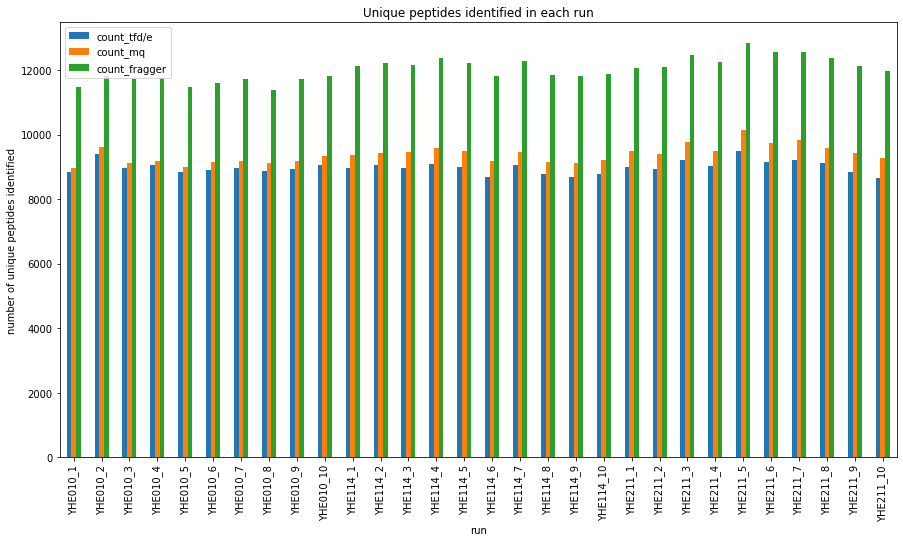

In [29]:
merged_df.plot(kind='bar', figsize=(15,8))
_ = plt.title("Unique peptides identified in each run")
_ = plt.xlabel("run")
_ = plt.ylabel("number of unique peptides identified")

## missing-ness heatmaps

In [30]:
# return True if we can include an extraction from the specified group, given the groups in which it was identified
# need to implement these rules differently for each experiment, probably best with a simple rules parameter file
def extract_from_group(extract_group, identification_run_names_l):
    result = False
    identification_groups_l = list(set([r.split('_')[1] for r in identification_run_names_l]))
    if extract_group == 'YHE010':
        result = extract_group in identification_groups_l
    else:
        result = True
    return result

#### prepare the TFD/E data

In [31]:
# gather the lower intensity decile
results_df.columns

Index(['sequence', 'charge', 'identifications', 'extractions',
       'identifications_d', 'id_perc_q_value', 'id_count_all_runs',
       'id_count_human_only_runs', 'id_number_of_proteins', 'id_protein',
       'id_species', 'extractions_l', 'ext_count_all_runs',
       'ext_count_human_only_runs'],
      dtype='object')

In [32]:
results_df.iloc[0].extractions_l

[{'run_name': 'P3856_YHE211_6_Slot1-1_1_5109',
  'prob_target': 0.9977026114449116,
  'intensity': 634,
  'inferred': 0},
 {'run_name': 'P3856_YHE211_10_Slot1-1_1_5113',
  'prob_target': 0.9663072699243022,
  'intensity': 591,
  'inferred': 0},
 {'run_name': 'P3856_YHE010_9_Slot1-1_1_5101',
  'prob_target': 0.9961015342255404,
  'intensity': 917,
  'inferred': 0},
 {'run_name': 'P3856_YHE211_8_Slot1-1_1_5111',
  'prob_target': 0.9955835397278335,
  'intensity': 490,
  'inferred': 0},
 {'run_name': 'P3856_YHE114_2_Slot1-1_1_5116',
  'prob_target': 0.996600080000057,
  'intensity': 434,
  'inferred': 0},
 {'run_name': 'P3856_YHE114_10_Slot1-1_1_5124',
  'prob_target': 0.7555150654380859,
  'intensity': 277,
  'inferred': 0},
 {'run_name': 'P3856_YHE010_1_Slot1-1_1_5093',
  'prob_target': 0.998727421935868,
  'intensity': 651,
  'inferred': 0},
 {'run_name': 'P3856_YHE114_6_Slot1-1_1_5120',
  'prob_target': 0.9893520859909466,
  'intensity': 546,
  'inferred': 0},
 {'run_name': 'P3856_YHE

In [33]:
sequences_l = []
for row in results_df.itertuples():
    for group_name in ['YHE114','YHE211','YHE010']:
        if extract_from_group(extract_group=group_name, identification_run_names_l=row.identifications_d['run_names']):
            for extraction in row.extractions_l:
                if group_name in extraction['run_name']:
                    short_run_name = '_'.join(extraction['run_name'].split('_Slot')[0].split('_')[1:3])
                    identified_in_run = extraction['run_name'] in row.identifications_d['run_names']
                    sequences_l.append((row.sequence, row.charge, row.id_perc_q_value, row.id_protein, row.id_species, short_run_name, group_name, extraction['intensity'], identified_in_run))
sequences_df = pd.DataFrame(sequences_l, columns=['sequence', 'charge', 'id_perc_q_value', 'protein', 'species', 'short_run_name', 'group','intensity','identified_in_run'])


In [34]:
sequences_df[sequences_df.species == 'E.COLI'].sample(n=5)

,sequence,charge,id_perc_q_value,protein,species,short_run_name,group,intensity,identified_in_run
89453,EAPLAIELDHDK,2,0.000165,sp|P68919|RL25_ECOLI,E.COLI,YHE114_8,YHE114,1152,False
506948,VM[15.9949]GDYTDIEIIEAHHR,2,0.001091,sp|P04036|DAPB_ECOLI,E.COLI,YHE211_7,YHE211,497,False
440663,SVEELNTELLNLLR,2,0.000004,sp|P0A7M6|RL29_ECOLI,E.COLI,YHE211_4,YHE211,718,False
396415,Q[-17.0265]TVDEALKDAQTR,2,0.000004,sp|P0AEX9|MALE_ECOLI,E.COLI,YHE114_6,YHE114,1543,True
491070,VEQAFELTDASAER,2,0.003554,sp|P36683|ACNB_ECOLI,E.COLI,YHE114_9,YHE114,798,False


In [35]:
# find the mean intensity for each peptide in each group
intensities_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge','group'], as_index=False):
    mean_intensity = group_df.intensity.mean()
    intensities_l.append((group_name[0], group_name[1], group_name[2], mean_intensity))
intensities_df = pd.DataFrame(intensities_l, columns=['sequence', 'charge', 'group', 'group_mean_intensity'])

In [36]:
# sort each group by descending intensity
intensities_df.sort_values(by=['group_mean_intensity'], ascending=False, inplace=True)

In [37]:
intensities_df.tail()

,sequence,charge,group,group_mean_intensity
25726,IRFPEHCGIGIKPCSEEGTK,4,YHE211,19.0
32008,LQAQEEQHQEVQK,2,YHE211,11.0
47421,SSTSSTSPSTSTSTSTSSTSSSSSSSSSSSSSSSGSGSIYGDLADF...,4,YHE211,10.0
6599,DGITNGAHWYDVEGGMQDYNYVWANCFEITLELSCCK,4,YHE211,10.0
42937,Q[-17.0265]VDGDNSHVEMK,2,YHE211,9.0


In [38]:
# make a separate DF for each group
yhe010_df = intensities_df[(intensities_df.group == 'YHE010')].copy()
yhe114_df = intensities_df[(intensities_df.group == 'YHE114')].copy()
yhe211_df = intensities_df[(intensities_df.group == 'YHE211')].copy()

In [39]:
# find the lowest-intensity peptides in each group
lower_number = 500
yhe010_lowest_df = yhe010_df.tail(lower_number)
yhe114_lowest_df = yhe114_df.tail(lower_number)
yhe211_lowest_df = yhe211_df.tail(lower_number)

## TFD/E heatmaps

#### plot YHE010

In [40]:
yhe010_df.tail(n=5)

,sequence,charge,group,group_mean_intensity
17042,GATYGKPVHHGVNQLK,3,YHE010,83.000000
29936,LILDVFCGSQMHFVR,3,YHE010,71.000000
30095,LKSIELDPSSPDSPPPCIIVCSHVNHELASPM[15.9949]LIEM[...,4,YHE010,68.000000
46484,SNNSETSSVAQSGSESK,2,YHE010,55.571429
29957,LIMTVTTPEM[15.9949]VM[15.9949]PSSMFLPAAVPDR,3,YHE010,41.000000


In [41]:
run_names_l = sorted(list(sequences_df[sequences_df.group == 'YHE010'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [42]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe010_lowest_df.itertuples():
    run_occurences_df = sequences_df[(sequences_df.sequence == row.sequence) & (sequences_df.charge == row.charge) & (sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

In [43]:
occurences_df.tail(n=10)

,YHE010_1,YHE010_2,YHE010_3,YHE010_4,YHE010_5,YHE010_6,YHE010_7,YHE010_8,YHE010_9,YHE010_10
"GGNIGDGGGAADR,2",0.000000,0.000000,0.000000,0.000000,0.000000,6.741467,0.000000,0.000000,0.000000,0.000000
"LGADESEEEGRR,2",0.000000,6.686501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"DLMQEDAENYSAWCNDWQHAIPTNGEGFQAFSQR,4",0.000000,0.000000,0.000000,0.000000,0.000000,6.672425,0.000000,0.000000,0.000000,0.000000
"AQAVSEDAGGNEGR,2",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.523562,0.000000,0.000000
"AEPCLPGPACPAFSAHSYTSNLGDYDEQALGIM[15.9949]QTLGVDR,4",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.409391,0.000000,0.000000,0.000000
"GATYGKPVHHGVNQLK,3",0.000000,0.000000,0.000000,0.000000,0.000000,4.906891,0.000000,0.000000,0.000000,7.087463
"LILDVFCGSQMHFVR,3",0.000000,0.000000,0.000000,6.149747,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"LKSIELDPSSPDSPPPCIIVCSHVNHELASPM[15.9949]LIEM[15.9949]GR,4",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.087463,0.000000,0.000000,0.000000
"SNNSETSSVAQSGSESK,2",6.169925,0.000000,5.169925,6.882643,5.044394,0.000000,5.392317,0.000000,5.954196,4.700440
"LIMTVTTPEM[15.9949]VM[15.9949]PSSMFLPAAVPDR,3",0.000000,0.000000,0.000000,0.000000,5.357552,0.000000,0.000000,0.000000,0.000000,0.000000


Text(0.5, 1, 'Lowest 500 peptides by mean intensity for YHE010 by TFD/E')

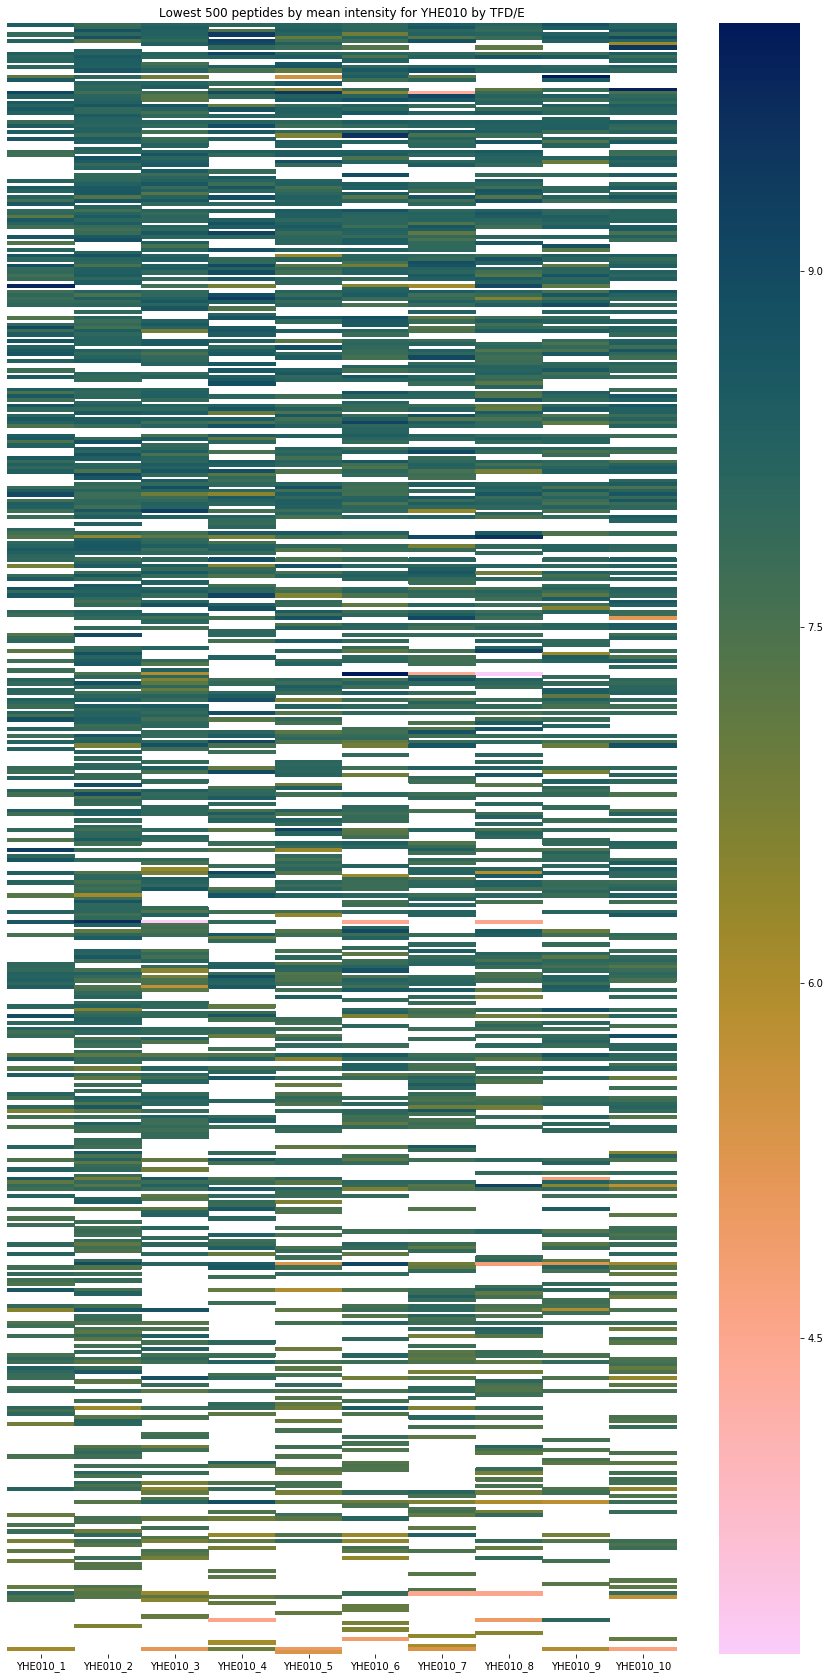

In [44]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap=cm.batlow_r, vmin=a[a > 0].min(), vmax=a.max(), mask=(occurences_df==0), linewidths=0)
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
# plt.title('Lowest {}% of peptides by intensity for YHE010'.format(int(lower_proportion*100)))
plt.title('Lowest {} peptides by mean intensity for YHE010 by TFD/E'.format(lower_number))

In [45]:
a[a > 0].min()

3.169925001442312

#### plot YHE114

In [46]:
run_names_l = sorted(list(sequences_df[sequences_df.group == 'YHE114'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [47]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe114_lowest_df.itertuples():
    run_occurences_df = sequences_df[(sequences_df.sequence == row.sequence) & (sequences_df.charge == row.charge) & (sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 500 peptides by mean intensity for YHE114 by TFD/E')

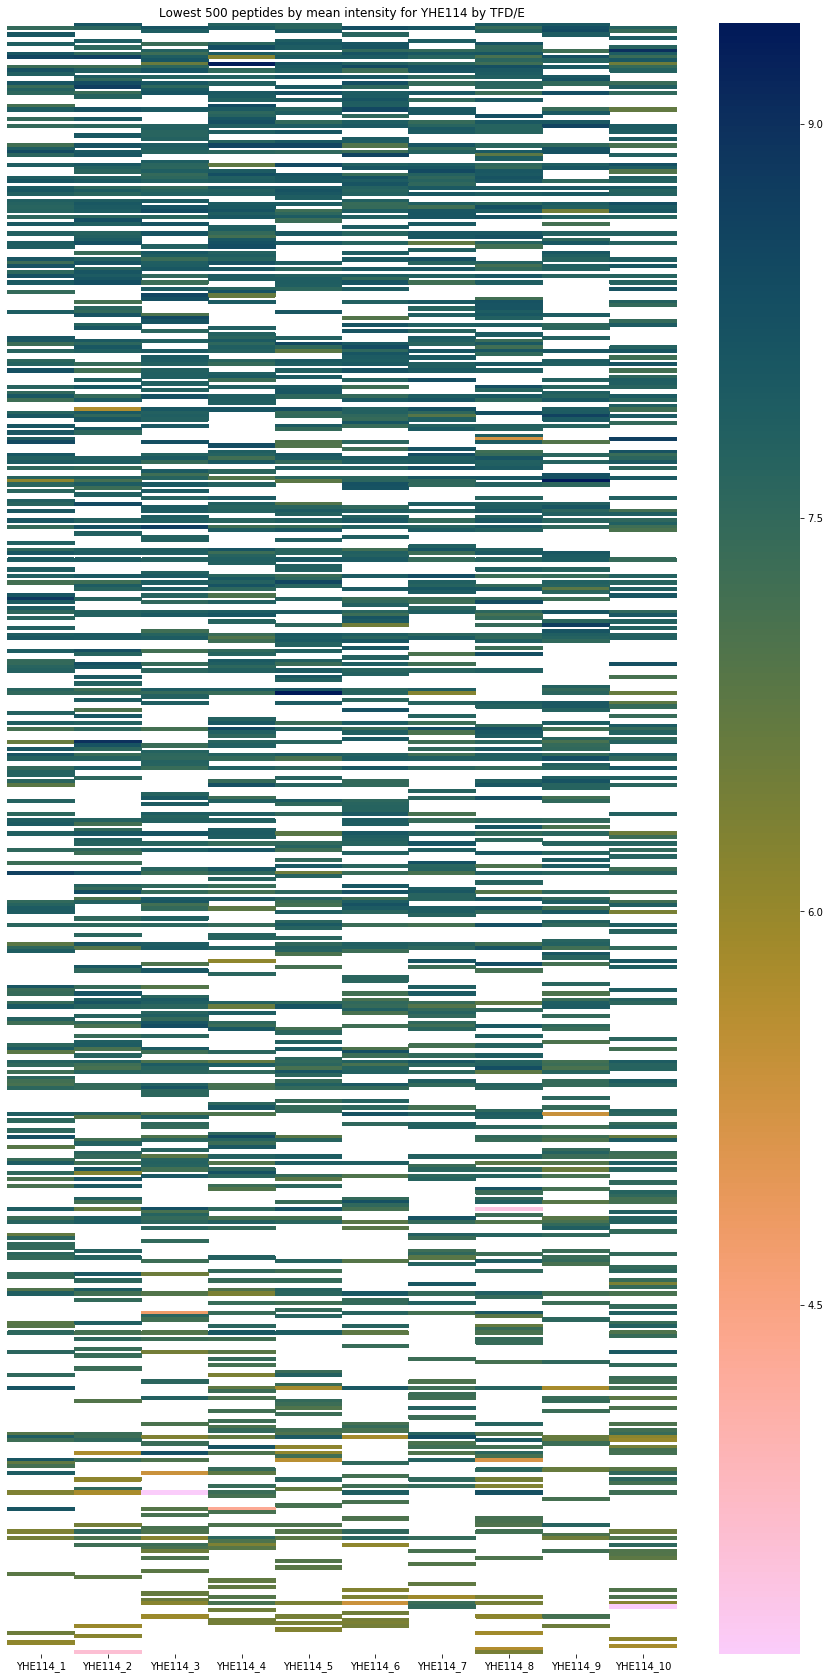

In [48]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap=cm.batlow_r, vmin=a[a > 0].min(), vmax=a.max(), mask=(occurences_df==0), linewidths=0)
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {} peptides by mean intensity for YHE114 by TFD/E'.format(lower_number))

#### plot YHE211

In [49]:
run_names_l = sorted(list(sequences_df[sequences_df.group == 'YHE211'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [50]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe211_lowest_df.itertuples():
    run_occurences_df = sequences_df[(sequences_df.sequence == row.sequence) & (sequences_df.charge == row.charge) & (sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 500 peptides by mean intensity for YHE211 by TFD/E')

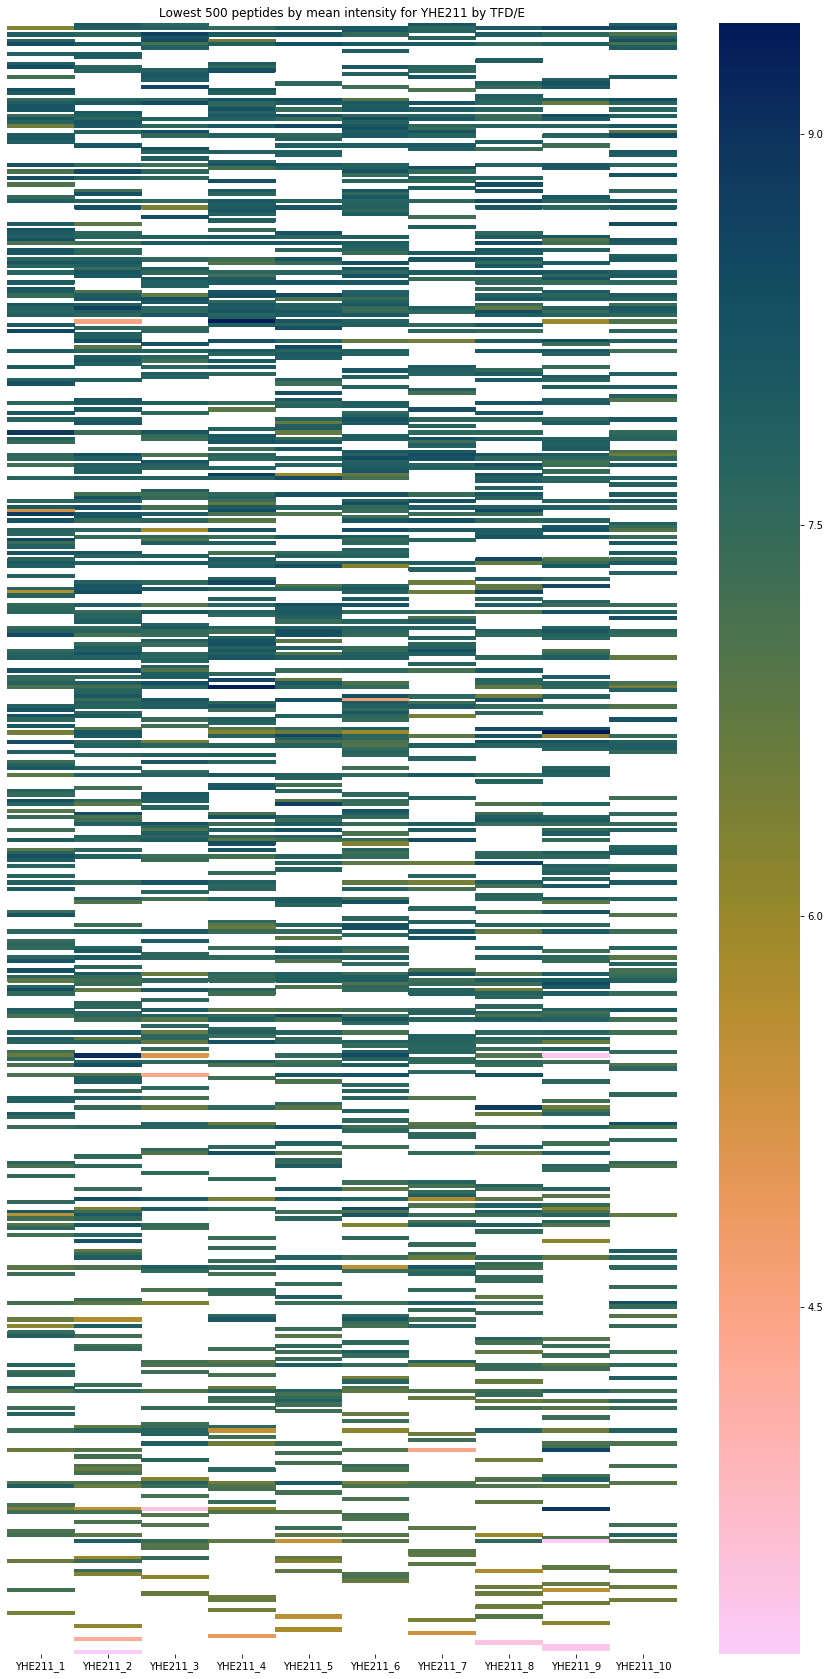

In [51]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap=cm.batlow_r, vmin=a[a > 0].min(), vmax=a.max(), mask=(occurences_df==0), linewidths=0)
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {} peptides by mean intensity for YHE211 by TFD/E'.format(lower_number))

## MaxQuant heatmaps

In [52]:
mq_results_df.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Type',
       'Raw file', 'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'Calibrated CCS', 'CCS length', 'Match time difference',
       'Match m/z difference', 'Match K0 difference', 'Match q-value',
       'M

In [53]:
mq_results_df.iloc[1466].Proteins

'sp|P31040|SDHA_HUMAN'

In [54]:
# get one reading for each unique peptide in each run, and count how many identifications and extractions (i.e. 
# matches) across each group. Note that a sequence can be counted as an identification and a match in the same file 
# (i.e. it's given a different score).
mq_sequences_l = []
unique_peptide_key_file = unique_peptide_key + ['Raw file']
for group_name,group_df in mq_results_df.groupby(unique_peptide_key_file, as_index=False):
    identified_in_file = (len(group_df[group_df.Type == 'TIMS-MULTI-MSMS']) > 0)
    short_run_name = '_'.join(group_name[3].split('_Slot')[0].split('_')[1:3])
    grp_name = short_run_name.split('_')[0]
    sorted_df = group_df.sort_values(by=['Intensity'], ascending=False, inplace=False)
    if identified_in_file:
        score = sorted_df.iloc[0]['Score']
    else:
        score = sorted_df.iloc[0]['Match score']
    intensity = sorted_df.iloc[0].Intensity
    protein = sorted_df.iloc[0].Proteins
    species = classify_protein(protein)
    mq_sequences_l.append((group_name[0], group_name[1], group_name[2], species, short_run_name, grp_name, identified_in_file, score, intensity))
mq_sequences_df = pd.DataFrame(mq_sequences_l, columns=['sequence','modifications','charge','species','short_run_name','group','identified_in_file','score','intensity'])


In [55]:
mq_sequences_df.sample(n=5)

,sequence,modifications,charge,species,short_run_name,group,identified_in_file,score,intensity
199631,LFQFLQAEPHNSLGK,Unmodified,2,HUMAN,YHE114_9,YHE114,False,199.700,17098.0
388469,VTPGSGALQGQSVSVWELLFYR,Unmodified,3,HUMAN,YHE114_6,YHE114,True,53.193,28526.0
244945,MNLASEPQEVLHIGSAHNR,Unmodified,3,HUMAN,YHE010_7,YHE010,True,69.201,13599.0
15887,ALASVLERPLPVNQR,Acetyl (Protein N-term),2,HUMAN,YHE010_4,YHE010,True,97.175,478740.0
77196,EGMAALQSDPWQQELYR,Unmodified,2,HUMAN,YHE211_2,YHE211,False,241.520,18336.0


In [56]:
# find the mean intensity for each peptide in each group
mq_intensities_l = []
for group_name,group_df in mq_sequences_df.groupby(['sequence','modifications','charge','group'], as_index=False):
    mean_intensity = group_df.intensity.mean()
    mq_intensities_l.append((group_name[0], group_name[1], group_name[2], group_name[3], mean_intensity))
mq_intensities_df = pd.DataFrame(mq_intensities_l, columns=['sequence', 'modifications', 'charge', 'group', 'group_mean_intensity'])

In [57]:
# sort each group by descending intensity
mq_intensities_df.sort_values(by=['group_mean_intensity'], ascending=False, inplace=True)

In [58]:
mq_intensities_df.tail()

,sequence,modifications,charge,group,group_mean_intensity
46385,VDNAYWLWTFQGR,Unmodified,2,YHE114,873.45
34372,NYLPLLEPVKPEPK,Unmodified,2,YHE211,869.28
8699,EATWTMSNITAGR,Unmodified,2,YHE010,756.94
3300,AQLAQDGVQLCALDDLDSK,Unmodified,2,YHE114,728.88
27256,LMAPYTPFLTELMYQNLK,Unmodified,2,YHE010,719.49


In [59]:
# make a separate DF for each group
yhe010_df = mq_intensities_df[(mq_intensities_df.group == 'YHE010')].copy()
yhe114_df = mq_intensities_df[(mq_intensities_df.group == 'YHE114')].copy()
yhe211_df = mq_intensities_df[(mq_intensities_df.group == 'YHE211')].copy()

In [60]:
# find the lowest-intensity peptides in each group
lower_number = 500
yhe010_lowest_df = yhe010_df.tail(lower_number)
yhe114_lowest_df = yhe114_df.tail(lower_number)
yhe211_lowest_df = yhe211_df.tail(lower_number)

#### plot YHE010

In [61]:
run_names_l = sorted(list(mq_sequences_df[mq_sequences_df.group == 'YHE010'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [62]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe010_lowest_df.itertuples():
    run_occurences_df = mq_sequences_df[(mq_sequences_df.sequence == row.sequence) & (mq_sequences_df.modifications == row.modifications) & (mq_sequences_df.charge == row.charge) & (mq_sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 500 peptides by mean intensity for YHE010 by MaxQuant')

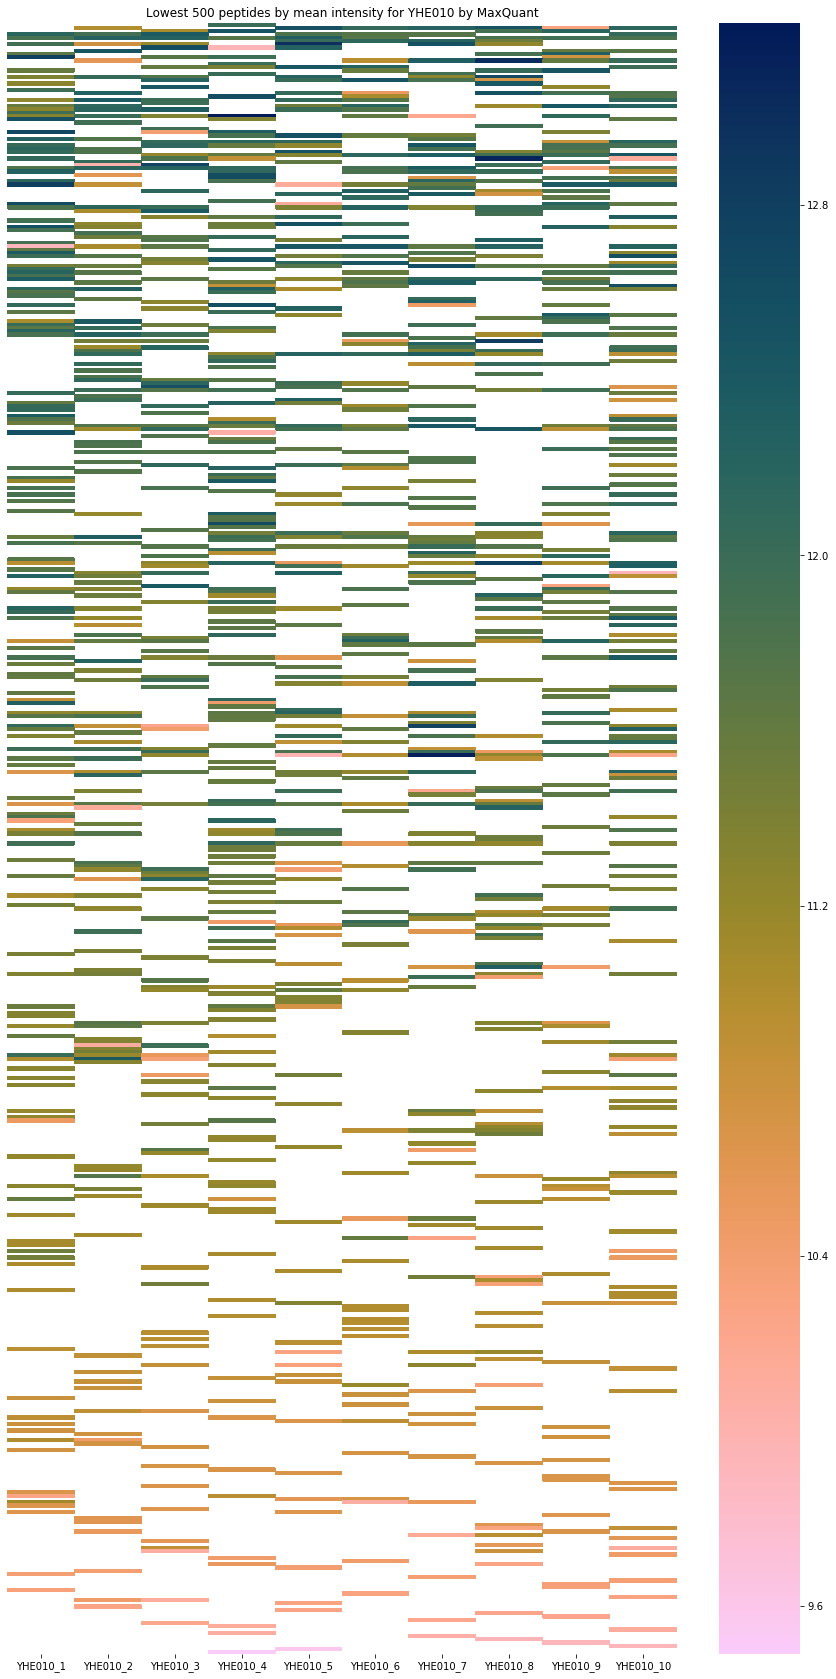

In [63]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap=cm.batlow_r, vmin=a[a > 0].min(), vmax=a.max(), mask=(occurences_df==0), linewidths=0)
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {} peptides by mean intensity for YHE010 by MaxQuant'.format(lower_number))


#### plot YHE114

In [64]:
run_names_l = sorted(list(mq_sequences_df[mq_sequences_df.group == 'YHE114'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [65]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe114_lowest_df.itertuples():
    run_occurences_df = mq_sequences_df[(mq_sequences_df.sequence == row.sequence) & (mq_sequences_df.modifications == row.modifications) & (mq_sequences_df.charge == row.charge) & (mq_sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 500 peptides by mean intensity for YHE114 by MaxQuant')

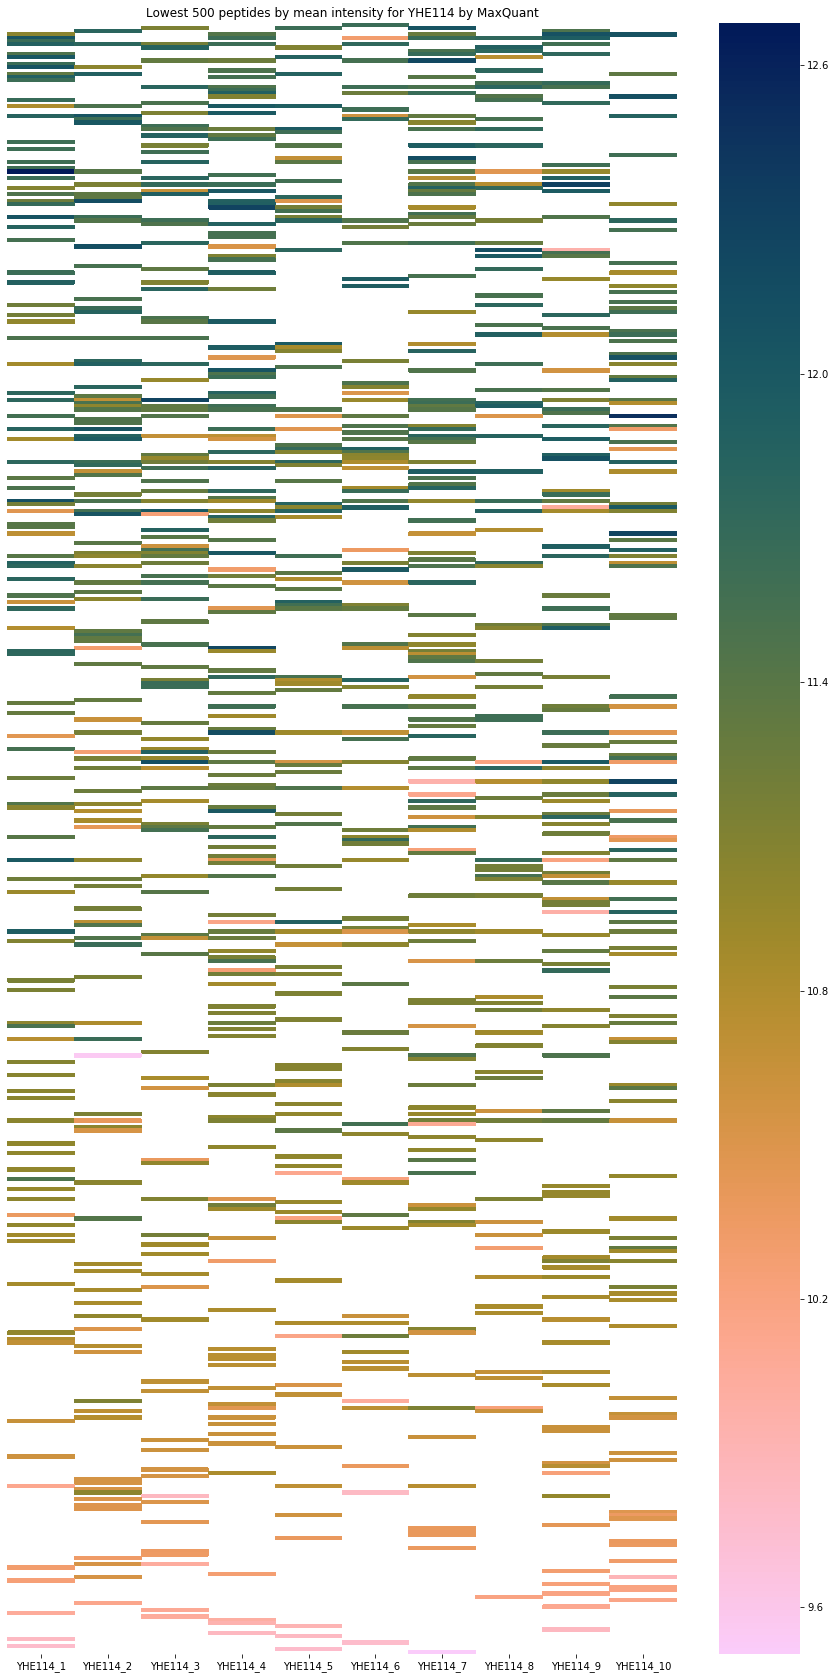

In [66]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap=cm.batlow_r, vmin=a[a > 0].min(), vmax=a.max(), mask=(occurences_df==0), linewidths=0)
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {} peptides by mean intensity for YHE114 by MaxQuant'.format(lower_number))

#### plot YHE211

In [67]:
run_names_l = sorted(list(mq_sequences_df[mq_sequences_df.group == 'YHE211'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [68]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe211_lowest_df.itertuples():
    run_occurences_df = mq_sequences_df[(mq_sequences_df.sequence == row.sequence) & (mq_sequences_df.modifications == row.modifications) & (mq_sequences_df.charge == row.charge) & (mq_sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 500 peptides by mean intensity for YHE211 by MaxQuant')

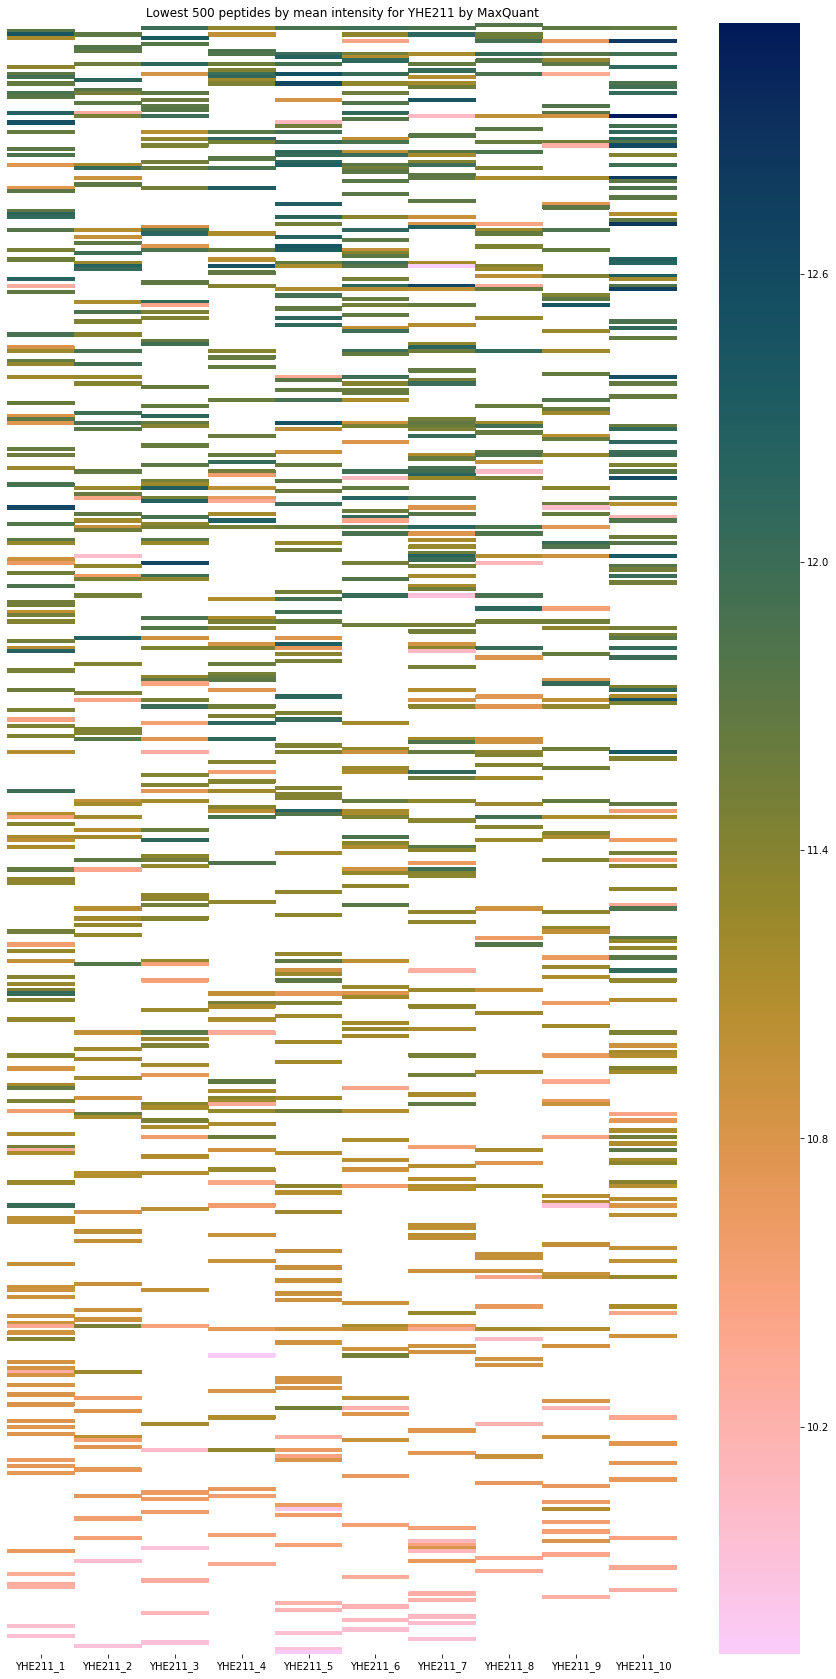

In [69]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap=cm.batlow_r, vmin=a[a > 0].min(), vmax=a.max(), mask=(occurences_df==0), linewidths=0)
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {} peptides by mean intensity for YHE211 by MaxQuant'.format(lower_number))

## Fragger heatmaps

In [70]:
# use the analysis with MBR
fragger_results_df = pd.read_csv('{}/MSstats-P3856.csv'.format(EXPERIMENT_DIR), sep=',')

In [71]:
fragger_sequences_df = fragger_results_df.copy()
fragger_sequences_df.columns

Index(['ProteinName', 'PeptideSequence', 'PrecursorCharge', 'FragmentIon',
       'ProductCharge', 'IsotopeLabelType', 'Condition', 'BioReplicate', 'Run',
       'Intensity'],
      dtype='object')

In [72]:
fragger_sequences_df['short_run_name'] = fragger_sequences_df.apply(lambda row: '_'.join(row.Run.split('_Slot')[0].split('_')[1:3]), axis=1)

In [73]:
fragger_sequences_df['species'] = fragger_sequences_df.apply(lambda row: classify_protein(row.ProteinName), axis=1)

In [74]:
fragger_sequences_df = fragger_sequences_df[fragger_sequences_df.Intensity.notnull()]
fragger_sequences_df = fragger_sequences_df[fragger_sequences_df.Intensity > 0]

In [75]:
fragger_sequences_df.sample(n=3)

,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity,short_run_name,species
593497,sp|Q8NFH5|NUP35_HUMAN,IFGESIMIGVKPC[57.0215]IDK,2,NaN,NaN,L,YHE010,7,P3856_YHE010_7_Slot1-1_1_5099,11380.413,YHE010_7,HUMAN
101722,sp|P05386|RLA1_HUMAN,ALANVNIGSLIC[57.0215]NVGAGGPAPAAGAAPAGGPAPSTAA...,4,NaN,NaN,L,YHE211,2,P3856_YHE211_2_Slot1-1_1_5105,78224.410,YHE211_2,HUMAN
261013,sp|P32352|ERG2_YEAST,HNAAEGLSTEDLLQDVR,2,NaN,NaN,L,YHE114,3,P3856_YHE114_3_Slot1-1_1_5117,29719.062,YHE114_3,YEAST


In [76]:
# find the mean intensity for each peptide in each group
fragger_intensities_l = []
for group_name,group_df in fragger_sequences_df.groupby(['PeptideSequence','PrecursorCharge','Condition'], as_index=False):
    mean_intensity = group_df.Intensity.mean()
    fragger_intensities_l.append((group_name[0], group_name[1], group_name[2], mean_intensity))
fragger_intensities_df = pd.DataFrame(fragger_intensities_l, columns=['sequence', 'charge', 'group', 'group_mean_intensity'])

In [77]:
# sort each group by descending intensity
fragger_intensities_df.sort_values(by=['group_mean_intensity'], ascending=False, inplace=True)

In [78]:
fragger_intensities_df.tail()

,sequence,charge,group,group_mean_intensity
48241,VC[57.0215]NYVNWIQQTIAAN,2,YHE211,357.09050
43509,STSSETDC[57.0215]NDNVPSHK,2,YHE114,324.62850
39256,RDLPNALDEK,2,YHE010,290.59800
14658,FNLSVIEDPSMK,2,YHE211,247.62599
137,AAGALLNGPPQFSTAPEIK,2,YHE010,214.77450


In [79]:
# make a separate DF for each group
yhe010_df = fragger_intensities_df[(fragger_intensities_df.group == 'YHE010')].copy()
yhe114_df = fragger_intensities_df[(fragger_intensities_df.group == 'YHE114')].copy()
yhe211_df = fragger_intensities_df[(fragger_intensities_df.group == 'YHE211')].copy()

In [80]:
# find the lowest-intensity peptides in each group
lower_number = 500
yhe010_lowest_df = yhe010_df.tail(lower_number)
yhe114_lowest_df = yhe114_df.tail(lower_number)
yhe211_lowest_df = yhe211_df.tail(lower_number)

#### plot YHE010

In [81]:
run_names_l = sorted(list(fragger_sequences_df[fragger_sequences_df.Condition == 'YHE010'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [82]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe010_lowest_df.itertuples():
    run_occurences_df = fragger_sequences_df[(fragger_sequences_df.PeptideSequence == row.sequence) & (fragger_sequences_df.PrecursorCharge == row.charge) & (fragger_sequences_df.Condition == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.Intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 500 peptides by mean intensity for YHE010 by MSFragger')

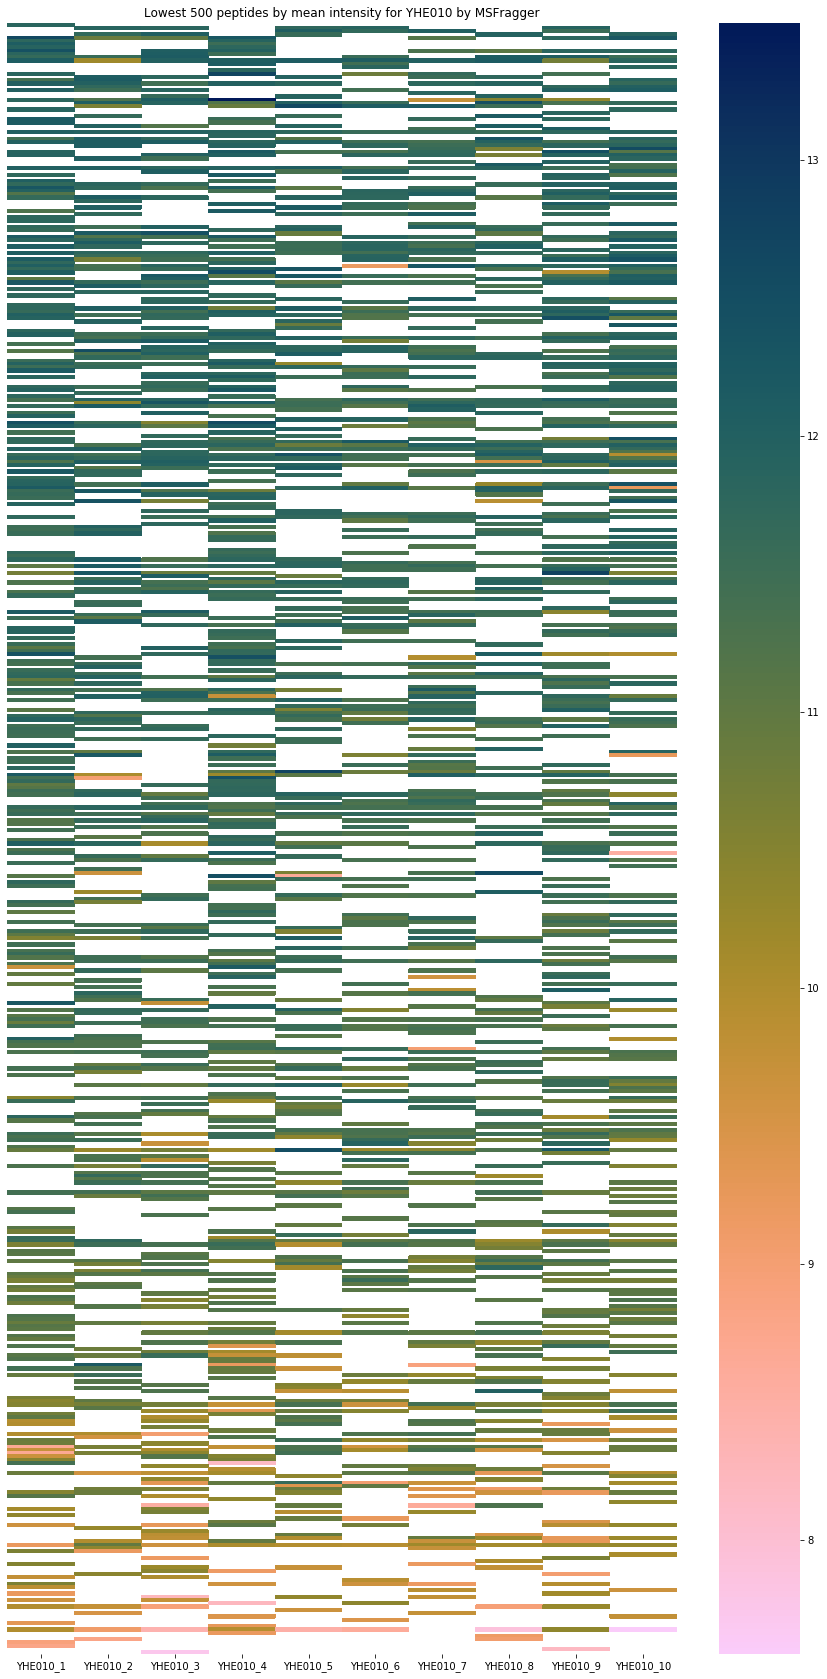

In [83]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap=cm.batlow_r, vmin=a[a > 0].min(), vmax=a.max(), mask=(occurences_df==0), linewidths=0)
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {} peptides by mean intensity for YHE010 by MSFragger'.format(lower_number))

#### plot YHE114

In [84]:
run_names_l = sorted(list(fragger_sequences_df[fragger_sequences_df.Condition == 'YHE114'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [85]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe114_lowest_df.itertuples():
    run_occurences_df = fragger_sequences_df[(fragger_sequences_df.PeptideSequence == row.sequence) & (fragger_sequences_df.PrecursorCharge == row.charge) & (fragger_sequences_df.Condition == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.Intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 500 peptides by intensity for YHE114 by MSFragger')

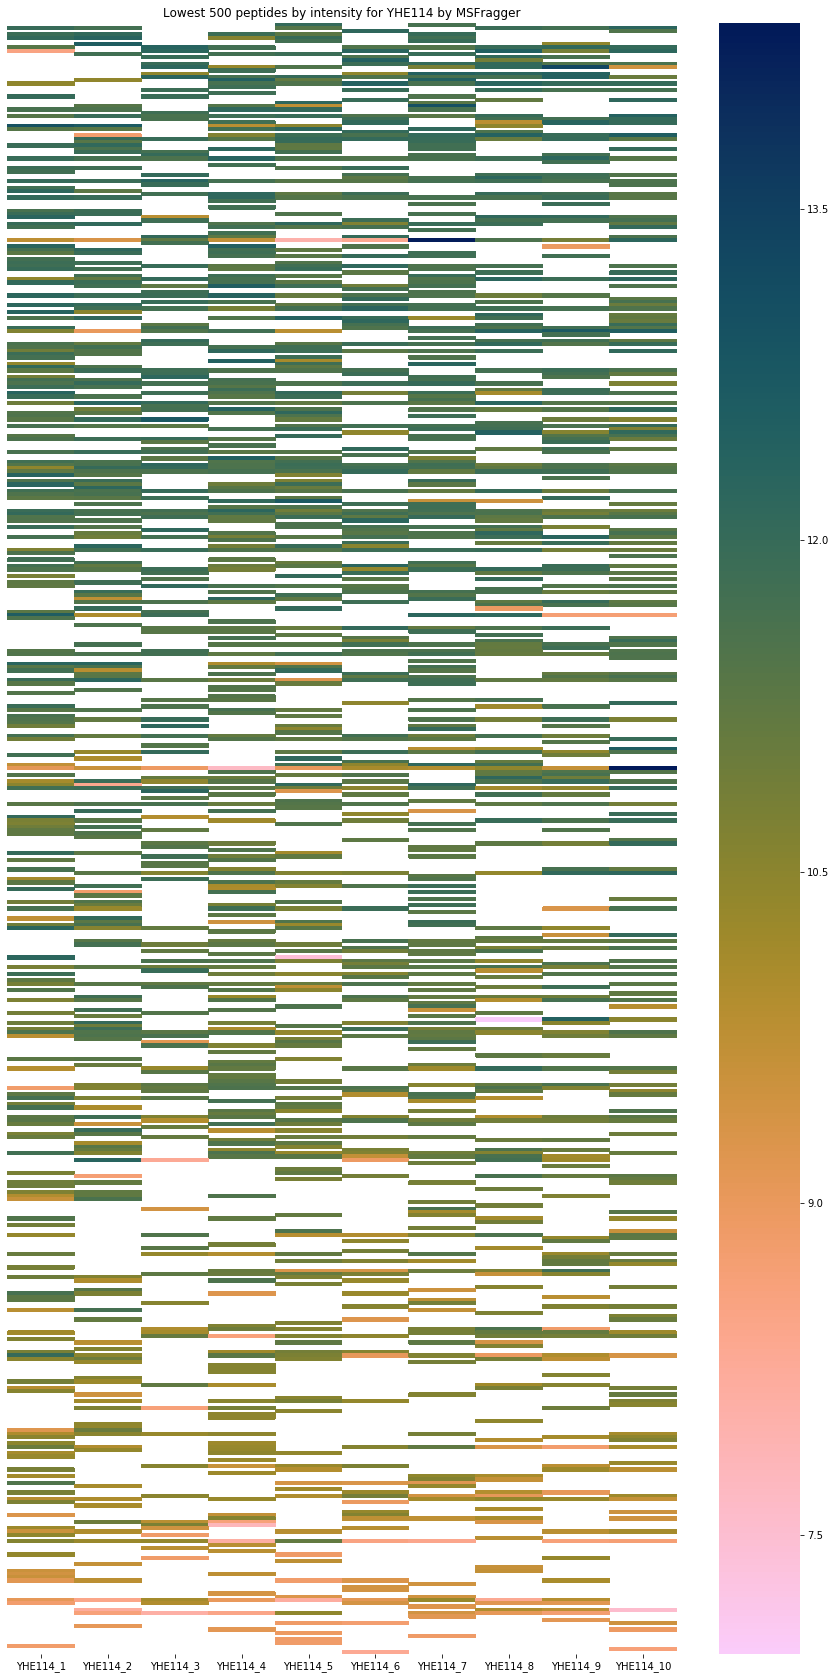

In [86]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap=cm.batlow_r, vmin=a[a > 0].min(), vmax=a.max(), mask=(occurences_df==0), linewidths=0)
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {} peptides by intensity for YHE114 by MSFragger'.format(lower_number))

#### plot YHE211

In [87]:
run_names_l = sorted(list(fragger_sequences_df[fragger_sequences_df.Condition == 'YHE211'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [88]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe211_lowest_df.itertuples():
    run_occurences_df = fragger_sequences_df[(fragger_sequences_df.PeptideSequence == row.sequence) & (fragger_sequences_df.PrecursorCharge == row.charge) & (fragger_sequences_df.Condition == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.Intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 500 peptides by mean intensity for YHE211 by MSFragger')

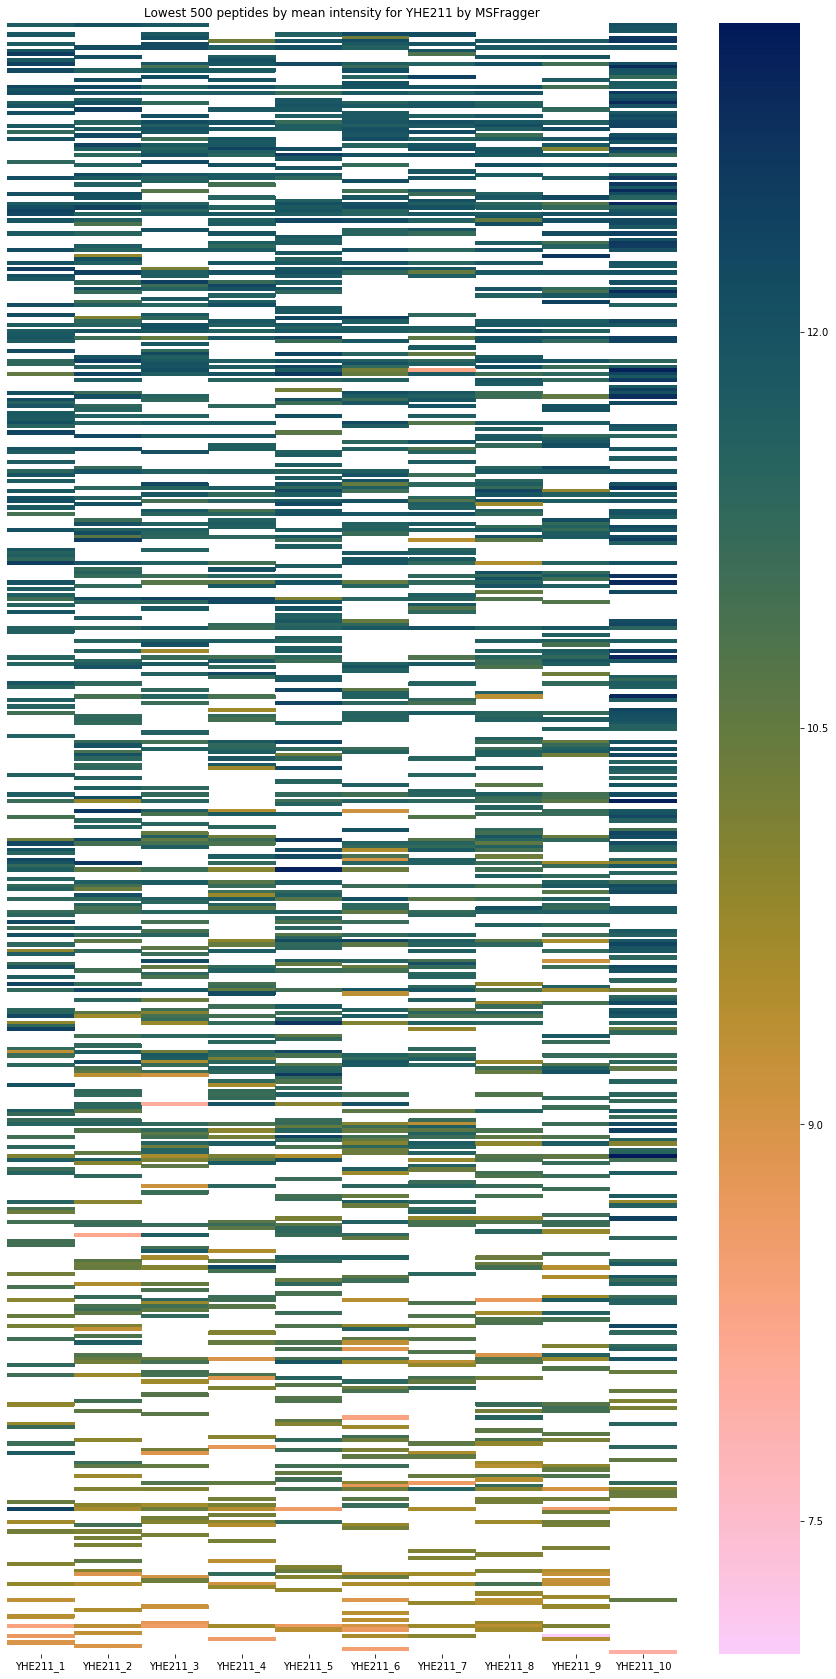

In [89]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap=cm.batlow_r, vmin=a[a > 0].min(), vmax=a.max(), mask=(occurences_df==0), linewidths=0)
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {} peptides by mean intensity for YHE211 by MSFragger'.format(lower_number))

## visualise the percentage of missing values across runs

#### prepare TFD/E results

In [90]:
subset_groups = ['YHE114']

In [91]:
tfde_subset_df = sequences_df[(sequences_df.group.isin(subset_groups))]

In [92]:
number_of_runs_in_subset = len(tfde_subset_df.short_run_name.unique())
print('there are {} {} runs in the experiment'.format(number_of_runs_in_subset, subset_groups))

there are 10 ['YHE114'] runs in the experiment


In [93]:
number_of_unique_sequences_tfde = len(tfde_subset_df.drop_duplicates(subset=['sequence', 'charge'], keep='first', inplace=False))
number_of_unique_sequences_tfde

22393

In [94]:
# count how many runs each sequence/charge was extracted from and classified as a target
sequence_occurences_l = []
for group_name,group_df in tfde_subset_df.groupby(['sequence','charge'], as_index=False):
    sequence_occurences_l.append((group_name, len(group_df.short_run_name.unique()), group_name[0], group_name[1]))
tfde_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence_charge','number_of_runs_extracted','sequence','charge'])

In [95]:
tfde_sequence_occurences_df['missing_files'] = number_of_runs_in_subset - tfde_sequence_occurences_df.number_of_runs_extracted

In [96]:
# display the number of missing values across the subset
tfde_missing_values = tfde_sequence_occurences_df.missing_files.sum() / (len(tfde_sequence_occurences_df) * number_of_runs_in_subset)

In [97]:
tfde_sequence_occurences_df.sample(n=3)

,sequence_charge,number_of_runs_extracted,sequence,charge,missing_files
4605,"(EMYLQSLFTPGQFTNEALCK, 2)",10,EMYLQSLFTPGQFTNEALCK,2,0
844,"(ALESTELLAENSADLPK, 2)",5,ALESTELLAENSADLPK,2,5
2018,"(CSLLPVVNNSGAICNSWK, 2)",10,CSLLPVVNNSGAICNSWK,2,0


In [98]:
run_count_l = []
for number_of_runs in range(1,number_of_runs_in_subset+1):
    run_count_l.append((number_of_runs, len(tfde_sequence_occurences_df[tfde_sequence_occurences_df.number_of_runs_extracted >= number_of_runs])))
tfde_run_count_df = pd.DataFrame(run_count_l, columns=['run_count','number_of_sequences'])

In [99]:
tfde_run_count_df['percent_quantified'] = tfde_run_count_df.number_of_sequences / number_of_unique_sequences_tfde * 100

#### prepare MQ results

In [100]:
mq_sequences_df.columns

Index(['sequence', 'modifications', 'charge', 'species', 'short_run_name',
       'group', 'identified_in_file', 'score', 'intensity'],
      dtype='object')

In [101]:
mq_subset_df = mq_sequences_df[(mq_sequences_df.group.isin(subset_groups))]

In [102]:
number_of_unique_sequences_mq = len(mq_subset_df.drop_duplicates(subset=['sequence','modifications','charge'], keep='first', inplace=False))
number_of_unique_sequences_mq

18112

In [103]:
# count how many runs each sequence/charge was extracted from
sequence_occurences_l = []
for group_name,group_df in mq_subset_df.groupby(['sequence', 'modifications', 'charge'], as_index=False):
    sequence_occurences_l.append((group_name[0], group_name[1], group_name[2], len(group_df.short_run_name.unique())))
mq_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence','modifications','charge','number_of_runs_extracted'])

In [104]:
run_count_l = []
for number_of_runs in range(1,number_of_runs_in_subset+1):
    run_count_l.append((number_of_runs, len(mq_sequence_occurences_df[mq_sequence_occurences_df.number_of_runs_extracted >= number_of_runs])))
mq_run_count_df = pd.DataFrame(run_count_l, columns=['run_count','number_of_sequences'])

In [105]:
mq_sequence_occurences_df['missing_files'] = number_of_runs_in_subset - mq_sequence_occurences_df.number_of_runs_extracted
mq_run_count_df['percent_quantified'] = mq_run_count_df.number_of_sequences / number_of_unique_sequences_mq * 100

In [106]:
# display the number of missing values across the subset
mq_missing_values = mq_sequence_occurences_df.missing_files.sum() / (len(mq_sequence_occurences_df) * number_of_runs_in_subset)

#### prepare Fragger results

In [107]:
fragger_subset_df = fragger_sequences_df[(fragger_sequences_df.Condition.isin(subset_groups))]

In [108]:
number_of_unique_sequences_fragger = len(fragger_subset_df.drop_duplicates(subset=['PeptideSequence', 'PrecursorCharge'], keep='first', inplace=False))
number_of_unique_sequences_fragger

18878

In [109]:
# count how many runs each sequence/charge was found in
sequence_occurences_l = []
for group_name,group_df in fragger_subset_df.groupby(['PeptideSequence','PrecursorCharge'], as_index=False):
    sequence_occurences_l.append((group_name[0], group_name[1], len(group_df.short_run_name.unique())))
fragger_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence','charge','number_of_runs_extracted'])

In [110]:
run_count_l = []
for number_of_runs in range(1,number_of_runs_in_subset+1):
    run_count_l.append((number_of_runs, len(fragger_sequence_occurences_df[fragger_sequence_occurences_df.number_of_runs_extracted >= number_of_runs])))
fragger_run_count_df = pd.DataFrame(run_count_l, columns=['run_count','number_of_sequences'])

In [111]:
fragger_sequence_occurences_df['missing_files'] = number_of_runs_in_subset - fragger_sequence_occurences_df.number_of_runs_extracted
fragger_run_count_df['percent_quantified'] = fragger_run_count_df.number_of_sequences / number_of_unique_sequences_fragger * 100

In [112]:
# display the number of missing values across the subset
fragger_missing_values = fragger_sequence_occurences_df.missing_files.sum() / (len(fragger_sequence_occurences_df) * number_of_runs_in_subset)

#### now plot the results

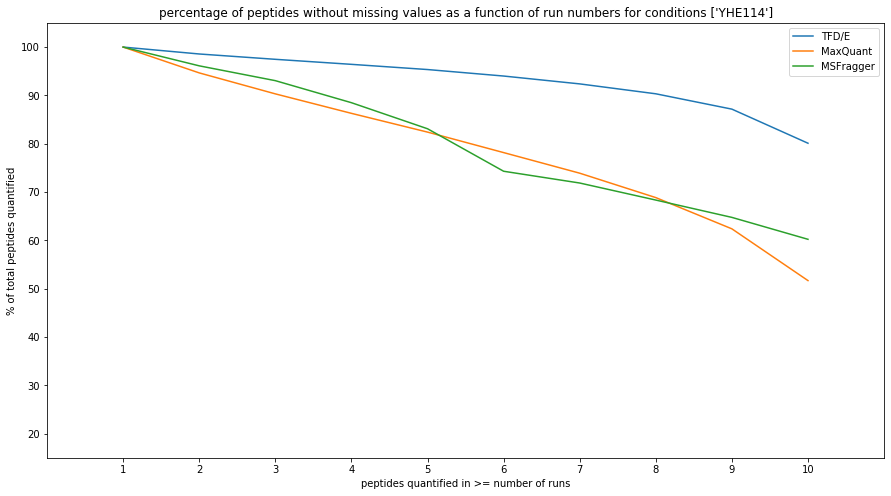

In [113]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('percentage of peptides without missing values as a function of run numbers for conditions {}'.format(subset_groups))

ax1.plot(tfde_run_count_df.run_count, tfde_run_count_df.percent_quantified, label='TFD/E')
ax1.plot(mq_run_count_df.run_count, mq_run_count_df.percent_quantified, label='MaxQuant')
ax1.plot(fragger_run_count_df.run_count, fragger_run_count_df.percent_quantified, label='MSFragger')

plt.xlabel('peptides quantified in >= number of runs')
plt.ylabel('% of total peptides quantified')
plt.ylim((15,105))
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
plt.legend(loc="best")

plt.show()

## missing-ness distributions

#### plot TFD/E results

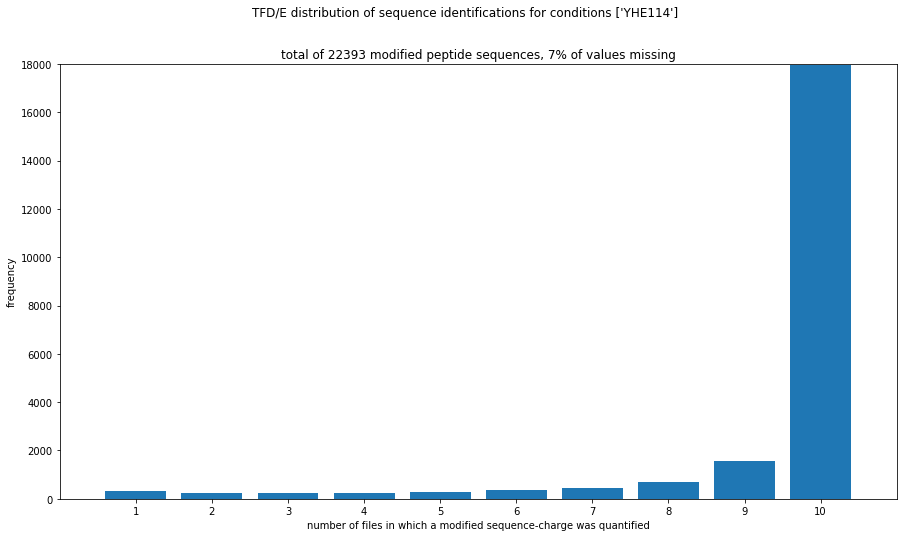

In [114]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('TFD/E distribution of sequence identifications for conditions {}'.format(subset_groups))
plt.title('total of {} modified peptide sequences, {}% of values missing'.format(number_of_unique_sequences_tfde, int(round(tfde_missing_values*100))))

counts = np.bincount(tfde_sequence_occurences_df.number_of_runs_extracted)
ax1.bar(range(number_of_runs_in_subset+1), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was quantified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
plt.ylim((0,18000))

plt.show()

#### plot MQ results

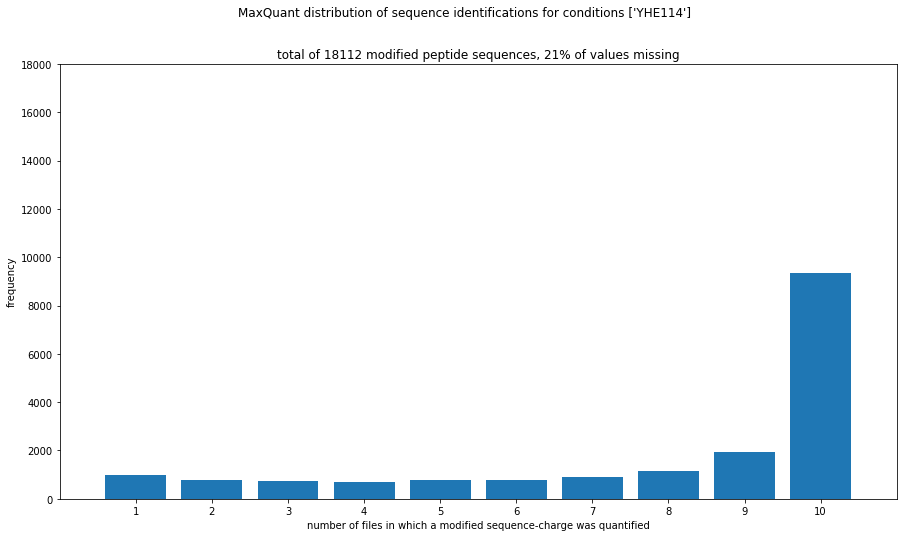

In [115]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('MaxQuant distribution of sequence identifications for conditions {}'.format(subset_groups))
plt.title('total of {} modified peptide sequences, {}% of values missing'.format(number_of_unique_sequences_mq, int(round(mq_missing_values*100))))

counts = np.bincount(mq_sequence_occurences_df.number_of_runs_extracted)
ax1.bar(range(number_of_runs_in_subset+1), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was quantified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
plt.ylim((0,18000))

plt.show()

#### plot Fragger results

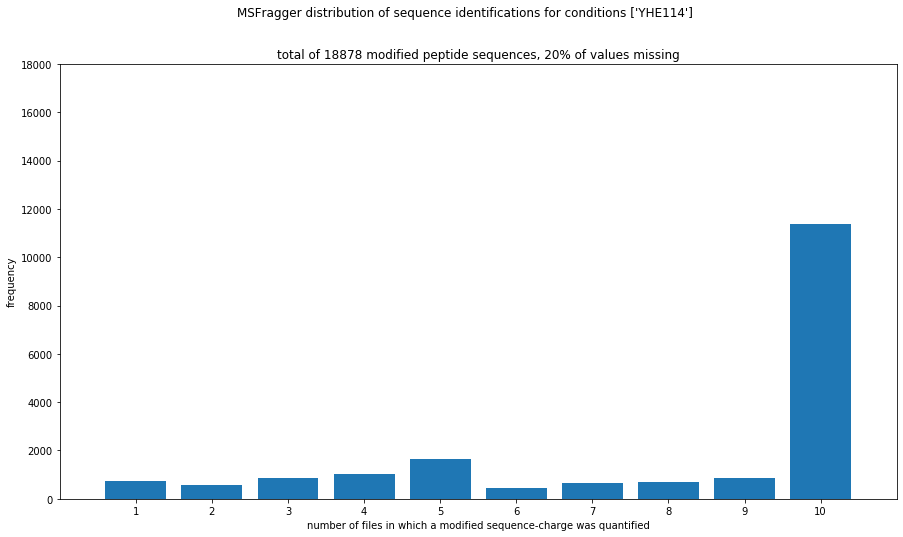

In [116]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('MSFragger distribution of sequence identifications for conditions {}'.format(subset_groups))
plt.title('total of {} modified peptide sequences, {}% of values missing'.format(number_of_unique_sequences_fragger, int(round(fragger_missing_values*100))))

counts = np.bincount(fragger_sequence_occurences_df.number_of_runs_extracted)
ax1.bar(range(number_of_runs_in_subset+1), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was quantified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
plt.ylim((0,18000))

plt.show()

## distribution of quantitative intensities

#### prepare TFD/E results

In [117]:
tfde_subset_df.sample(n=3)

,sequence,charge,id_perc_q_value,protein,species,short_run_name,group,intensity,identified_in_run
453425,TFTTVSDNQTTVQFPVYQGER,2,0.000004,sp|P40150|SSB2_YEAST,YEAST,YHE114_3,YHE114,1593,True
456005,TGSEMLQELLGFSPLKPLCR,3,0.000004,sp|Q86U38|NOP9_HUMAN,HUMAN,YHE114_1,YHE114,1090,True
227344,ILDAVVAQEPLHR,2,0.000004,sp|Q15029|U5S1_HUMAN,HUMAN,YHE114_7,YHE114,3150,True


In [118]:
# calculate the intensity mean for peptides without missing values
tfde_intensities_l = []
for group_name,group_df in tfde_subset_df.groupby(['sequence','charge'], as_index=False):
    if len(group_df.short_run_name.unique()) == number_of_runs_in_subset:
        intensity_mean = group_df.intensity.mean()
        tfde_intensities_l.append((','.join([group_name[0],group_name[1].astype('str')]),intensity_mean,'TFD/E'))
tfde_intensities_df = pd.DataFrame(tfde_intensities_l, columns=['sequence','intensity','method'])
tfde_intensities_df['intensity_adjusted'] = tfde_intensities_df.intensity - np.min(tfde_intensities_df.intensity)
tfde_intensities_df.intensity_adjusted.replace(to_replace=[0.0], value=1.0, inplace=True)

#### prepare MQ results

In [119]:
mq_subset_df.sample(n=3)

,sequence,modifications,charge,species,short_run_name,group,identified_in_file,score,intensity
121431,GFGFVLFK,Unmodified,1,HUMAN,YHE114_7,YHE114,False,102.980,26789.0
107266,FNHPEIVQLVSELEAER,Unmodified,2,HUMAN,YHE114_7,YHE114,True,22.724,126910.0
296345,QYEQQTYQVIPEVIK,Unmodified,2,HUMAN,YHE114_4,YHE114,False,259.700,4201.2


In [120]:
# calculate the intensity mean for peptides without missing values
mq_intensities_l = []
for group_name,group_df in mq_subset_df.groupby(['sequence','modifications','charge'], as_index=False):
    if len(group_df.short_run_name.unique()) == number_of_runs_in_subset:
        intensity_mean = group_df.intensity.mean()
        mq_intensities_l.append((','.join([group_name[0],group_name[1],group_name[2].astype('str')]),intensity_mean,'MaxQuant'))
mq_intensities_df = pd.DataFrame(mq_intensities_l, columns=['sequence','intensity','method'])
mq_intensities_df['intensity_adjusted'] = mq_intensities_df.intensity - np.min(mq_intensities_df.intensity)
mq_intensities_df.intensity_adjusted.replace(to_replace=[0.0], value=1.0, inplace=True)

#### prepare Fragger results

In [121]:
fragger_subset_df.sample(n=3)

,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity,short_run_name,species
218599,sp|P22943|HSP12_YEAST,DNAEGQGESLADQAR,2,NaN,NaN,L,YHE114,9,P3856_YHE114_9_Slot1-1_1_5123,56402.598,YHE114_9,YEAST
427933,sp|P98171|RHG04_HUMAN,ELLQELAEFMR,2,NaN,NaN,L,YHE114,3,P3856_YHE114_3_Slot1-1_1_5117,11797.723,YHE114_3,HUMAN
409458,sp|P62906|RL10A_HUMAN,FSVC[57.0215]VLGDQQHC[57.0215]DEAK,2,NaN,NaN,L,YHE114,8,P3856_YHE114_8_Slot1-1_1_5122,120838.790,YHE114_8,HUMAN


In [122]:
# calculate the intensity mean for peptides without missing values
fragger_intensities_l = []
for group_name,group_df in fragger_subset_df.groupby(['PeptideSequence', 'PrecursorCharge'], as_index=False):
    if len(group_df['Run'].unique()) == number_of_runs_in_subset:
        intensity_mean = group_df.Intensity.mean()
        fragger_intensities_l.append((','.join([group_name[0],group_name[1].astype('str')]),intensity_mean,'MSFragger'))
fragger_intensities_df = pd.DataFrame(fragger_intensities_l, columns=['sequence','intensity','method'])
fragger_intensities_df['intensity_adjusted'] = fragger_intensities_df.intensity - np.min(fragger_intensities_df.intensity)
fragger_intensities_df.intensity_adjusted.replace(to_replace=[0.0], value=1.0, inplace=True)

In [123]:
tfde_intensities_df['intensity_log'] = np.log10(tfde_intensities_df.intensity)
mq_intensities_df['intensity_log'] = np.log10(mq_intensities_df.intensity)
fragger_intensities_df['intensity_log'] = np.log10(fragger_intensities_df.intensity)

In [124]:
tfde_intensities_df['intensity_adjusted_log'] = tfde_intensities_df.intensity_log - np.min(tfde_intensities_df.intensity_log)
mq_intensities_df['intensity_adjusted_log'] = mq_intensities_df.intensity_log - np.min(mq_intensities_df.intensity_log)
fragger_intensities_df['intensity_adjusted_log'] = fragger_intensities_df.intensity_log - np.min(fragger_intensities_df.intensity_log)

#### consolidate the data

In [125]:
intensities_l = [tfde_intensities_df,mq_intensities_df,fragger_intensities_df]
intensities_df = pd.concat(intensities_l, sort=False)

In [126]:
intensities_df.sample(n=3)

,sequence,intensity,method,intensity_adjusted,intensity_log,intensity_adjusted_log
4394,"FFDSFGNLSSPSAILGNPK,2",6000.0,TFD/E,5823.60,3.778151,1.531653
16118,"VHHEPQLSDK,2",1001.1,TFD/E,824.70,3.000477,0.753979
7961,"TQMLDQEELLASTR,Unmodified,2",33944.2,MaxQuant,29477.26,4.530766,0.880755


#### produce the plot

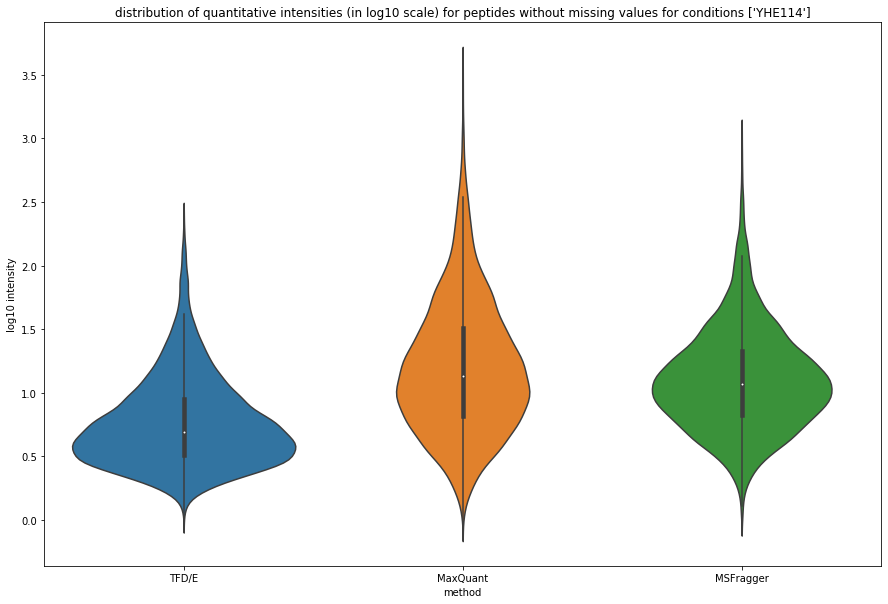

In [127]:
plt.figure(figsize=(15,10))
ax = sns.violinplot(x=intensities_df.method, y=intensities_df.intensity_adjusted_log)
_ = plt.ylabel("log10 intensity")
_ = plt.title('distribution of quantitative intensities (in log10 scale) for peptides without missing values for conditions {}'.format(subset_groups))

In [128]:
# orders of magnitude
intensities_df.groupby('method')['intensity_adjusted_log'].agg(np.ptp)

/Users/darylwilding-mcbride/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


method
MSFragger    3.023449
MaxQuant     3.552658
TFD/E        2.393660
Name: intensity_adjusted_log, dtype: float64

In [129]:
# number of peptides that have no missing values
intensities_df.groupby('method')['intensity_adjusted_log'].count()

method
MSFragger    11368
MaxQuant      9359
TFD/E        17937
Name: intensity_adjusted_log, dtype: int64

## distribution of CV

#### TFD/E analysis

In [130]:
tfde_subset_df.sample(n=3)

,sequence,charge,id_perc_q_value,protein,species,short_run_name,group,intensity,identified_in_run
63303,DHLVPDPGCHYDQLIEINLSELKPHINGPFTPDLAHPVAEVGK,4,0.000061,sp|Q99798|ACON_HUMAN,HUMAN,YHE114_8,YHE114,301,True
46171,CITDTLQELVNQSK,2,0.000986,sp|O75694|NU155_HUMAN,HUMAN,YHE114_8,YHE114,526,False
33274,AQVDSSFLSLYDSHVAK,2,0.000004,sp|Q8N2F6|ARM10_HUMAN,HUMAN,YHE114_1,YHE114,587,False


In [131]:
# for each sequence, find the CV
sequence_cv_l = []
for group_name,group_df in tfde_subset_df.groupby(['sequence','charge']):
    if len(group_df) >= 2:
        intensity_cv = np.std(group_df.intensity) / np.mean(group_df.intensity)
        sequence_cv_l.append((group_name[0], group_name[1], intensity_cv))
sequence_cv_df = pd.DataFrame(sequence_cv_l, columns=['sequence','charge','intensity_cv'])

In [132]:
sequence_cv_df.sample(n=3)

,sequence,charge,intensity_cv
20027,VLAVNQENEHLM[15.9949]EDYEK,2,0.193882
18037,TESDDLHTFLLEIK,2,0.426186
15243,Q[-17.0265]AEDESDREVEGGR,2,0.277389


In [133]:
sequence_cv_df[sequence_cv_df.intensity_cv > 0.25].sample(n=5)

,sequence,charge,intensity_cv
4611,ENSPGSNGQYSIVEMK,2,0.753970
16232,RTEEGPTLSYGR,2,0.311292
3657,EDGLPLCTSVDNENDPSLFEQK,2,0.312124
21843,YQHGLGTPDLR,2,0.421532
5682,FLSAPEAVEYGLVDSILTHR,3,0.281068


In [134]:
results_df[(results_df.sequence == 'HVLTGSADNSCR') & (results_df.charge == 2)]

,sequence,charge,identifications,extractions,identifications_d,id_perc_q_value,id_count_all_runs,id_count_human_only_runs,id_number_of_proteins,id_protein,id_species,extractions_l,ext_count_all_runs,ext_count_human_only_runs
8799,HVLTGSADNSCR,2,"{""perc_q_value"": 3.817231e-06, ""run_names"": [""...","[{""run_name"": ""P3856_YHE211_6_Slot1-1_1_5109"",...","{'perc_q_value': 3.817231e-06, 'run_names': ['...",0.000004,30,10,1,sp|Q13347|EIF3I_HUMAN,HUMAN,"[{'run_name': 'P3856_YHE211_6_Slot1-1_1_5109',...",30,10


In [135]:
tfde_subset_df[(tfde_subset_df.sequence == 'HVLTGSADNSCR') & (tfde_subset_df.charge == 2)]

,sequence,charge,id_perc_q_value,protein,species,short_run_name,group,intensity,identified_in_run
209384,HVLTGSADNSCR,2,0.000004,sp|Q13347|EIF3I_HUMAN,HUMAN,YHE114_2,YHE114,273,True
209385,HVLTGSADNSCR,2,0.000004,sp|Q13347|EIF3I_HUMAN,HUMAN,YHE114_10,YHE114,458,True
209386,HVLTGSADNSCR,2,0.000004,sp|Q13347|EIF3I_HUMAN,HUMAN,YHE114_6,YHE114,1073,True
209387,HVLTGSADNSCR,2,0.000004,sp|Q13347|EIF3I_HUMAN,HUMAN,YHE114_7,YHE114,248,True
209388,HVLTGSADNSCR,2,0.000004,sp|Q13347|EIF3I_HUMAN,HUMAN,YHE114_5,YHE114,154,True
209389,HVLTGSADNSCR,2,0.000004,sp|Q13347|EIF3I_HUMAN,HUMAN,YHE114_3,YHE114,6423,True
209390,HVLTGSADNSCR,2,0.000004,sp|Q13347|EIF3I_HUMAN,HUMAN,YHE114_4,YHE114,297,True
209391,HVLTGSADNSCR,2,0.000004,sp|Q13347|EIF3I_HUMAN,HUMAN,YHE114_1,YHE114,1717,True
209392,HVLTGSADNSCR,2,0.000004,sp|Q13347|EIF3I_HUMAN,HUMAN,YHE114_9,YHE114,527,True
209393,HVLTGSADNSCR,2,0.000004,sp|Q13347|EIF3I_HUMAN,HUMAN,YHE114_8,YHE114,380,True


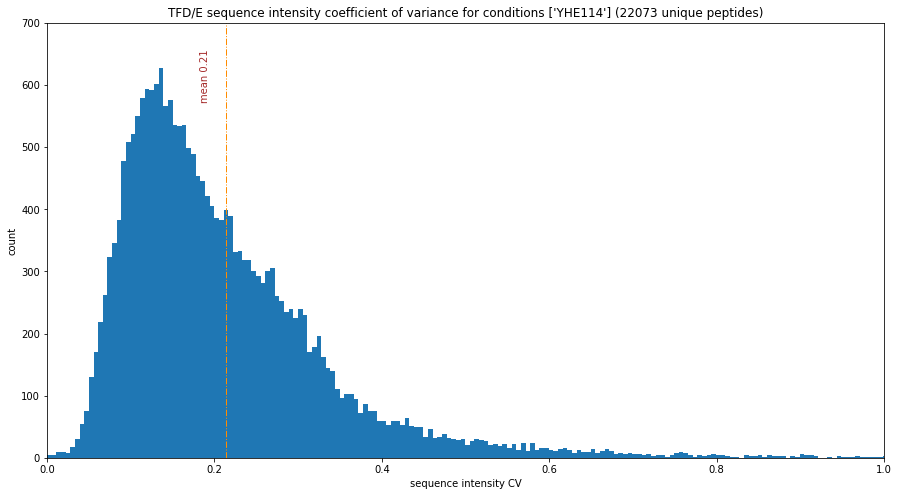

In [189]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 500
values = sequence_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
plt.title('TFD/E sequence intensity coefficient of variance for conditions {} ({} unique peptides)'.format(subset_groups,len(sequence_cv_df)))
plt.xlim((0,1))
plt.ylim((0,700))

plt.show()

#### MQ analysis

In [137]:
# for each sequence, find the CV
sequence_cv_l = []
for group_name,group_df in mq_subset_df.groupby(['sequence','modifications','charge']):
    if len(group_df) >= 2:
        intensity_cv = np.std(group_df.intensity) / np.mean(group_df.intensity)
        sequence = ','.join([group_name[0],group_name[1],group_name[2].astype('str')])
        sequence_cv_l.append((sequence, intensity_cv))
mq_sequence_cv_df = pd.DataFrame(sequence_cv_l, columns=['sequence','intensity_cv'])

In [138]:
mq_sequence_cv_df.sample(n=3)

,sequence,intensity_cv
12883,"SGLDSVSSWLPLAK,Unmodified,2",0.276963
9308,"LQQQFYPVQPVLMAINNIAR,Unmodified,3",0.462743
1789,"DATWSPLNHSLLTTVGWDHQVVHHVVPTEPLPAPGPASVTE,Unmo...",0.169544


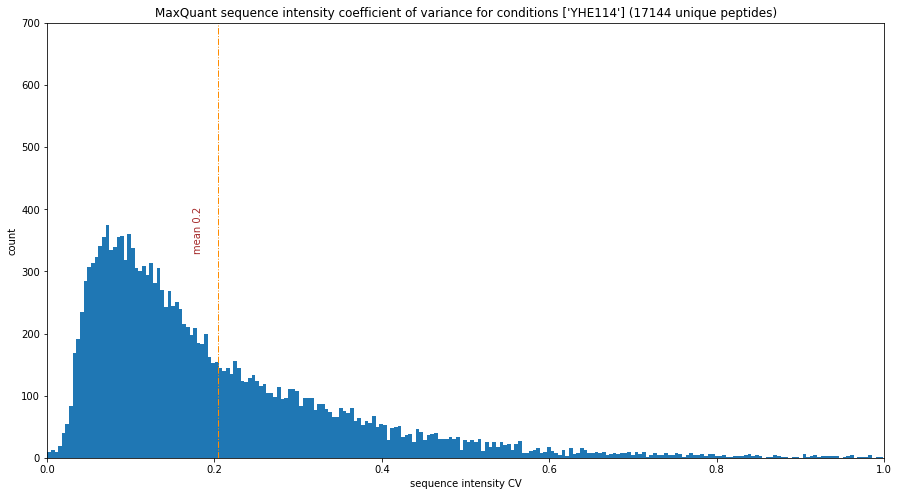

In [190]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 500
values = mq_sequence_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
plt.title('MaxQuant sequence intensity coefficient of variance for conditions {} ({} unique peptides)'.format(subset_groups, len(mq_sequence_cv_df)))
plt.xlim((0,1))
plt.ylim((0,700))

plt.show()

#### Fragger analysis

In [140]:
# for each sequence, find the CV
sequence_cv_l = []
for group_name,group_df in fragger_subset_df.groupby(['PeptideSequence', 'PrecursorCharge']):
    if len(group_df) >= 2:
        intensity_cv = np.std(group_df.Intensity) / np.mean(group_df.Intensity)
        sequence = ','.join([group_name[0],group_name[1].astype('str')])
        sequence_cv_l.append((sequence, intensity_cv))
fragger_sequence_cv_df = pd.DataFrame(sequence_cv_l, columns=['sequence','intensity_cv'])

In [141]:
fragger_sequence_cv_df.sample(n=3)

,sequence,intensity_cv
17111,"YAHWVVSQPPDTYLKPLMTELLK,4",0.150854
10913,"MSDILAEGITIVEDINK,3",0.161457
2004,"DFMIQGGDFVNGDGTGVASIYR,2",0.300780


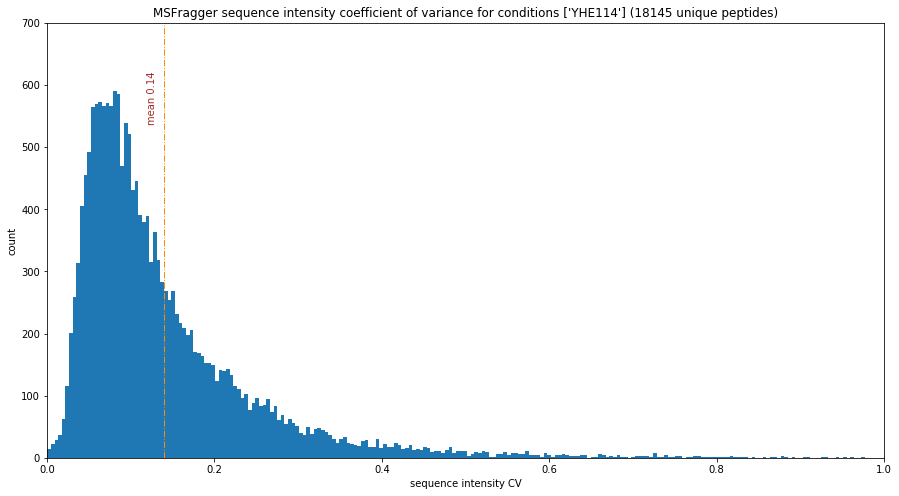

In [191]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 500
values = fragger_sequence_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
plt.title('MSFragger sequence intensity coefficient of variance for conditions {} ({} unique peptides)'.format(subset_groups,len(fragger_sequence_cv_df)))
plt.xlim((0,1))
plt.ylim((0,700))

plt.show()

## comparison of peptide intensity in different experiment conditions

In [143]:
# the experiment conditions to compare
groupA = 'YHE114'
groupA_number_of_runs = 10
groupB = 'YHE211'
groupB_number_of_runs = 10

#### TFD/E analysis

In [144]:
sequences_df.columns

Index(['sequence', 'charge', 'id_perc_q_value', 'protein', 'species',
       'short_run_name', 'group', 'intensity', 'identified_in_run'],
      dtype='object')

In [145]:
sequences_df.identified_in_run.sum()

265904

In [146]:
len(sequences_df[sequences_df.identified_in_run == True])

265904

In [147]:
# for each sequence and charge, if it was found in more than half the runs, 
# find the mean intensity in each group, then find the intensity ratio between groups
sequence_occurences_in_group = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    sequence_in_A_df = group_df[group_df.group == groupA]
    sequence_in_B_df = group_df[group_df.group == groupB]
    if (
            (sequence_in_A_df.identified_in_run.sum() > 0) and            # must have at least one ID in the group
            (sequence_in_B_df.identified_in_run.sum() > 0) and
            (len(sequence_in_A_df) >= int(groupA_number_of_runs / 2)) and # must have been extracted from more than half the runs in the group
            (len(sequence_in_B_df) >= int(groupB_number_of_runs / 2))
            ):
        intensity_A = sequence_in_A_df.intensity.mean()
        intensity_B = sequence_in_B_df.intensity.mean()
        species = group_df.iloc[0].species
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_group.append((sequence, charge, species, intensity_A, intensity_B))

In [148]:
sequence_occurences_in_group_df = pd.DataFrame(sequence_occurences_in_group, columns=['sequence','charge','species','intensity_A','intensity_B'])

In [149]:
sequence_occurences_in_group_df['intensity_ratio'] = sequence_occurences_in_group_df.intensity_B / sequence_occurences_in_group_df.intensity_A

In [150]:
sequence_occurences_in_group_df['intensity_ratio_log'] = np.log2(sequence_occurences_in_group_df['intensity_ratio'])

#### focus on an E.coli peptide that has similar intensity in the two conditions

In [151]:
possible_dup_df = sequence_occurences_in_group_df[(sequence_occurences_in_group_df.intensity_A > 1000) & (np.log2(sequence_occurences_in_group_df.intensity_ratio) > -0.5) & (sequence_occurences_in_group_df.species == 'E.COLI')]
possible_dup_df.sample(n=5)

,sequence,charge,species,intensity_A,intensity_B,intensity_ratio,intensity_ratio_log
5824,LINDAYDSEYFATK,2,E.COLI,4229.1,4169.500000,0.985907,-0.020476
9214,TAIESALTALETALK,2,E.COLI,1454.9,1064.600000,0.731734,-0.450609
9092,STVGHDLNLDVCSK,2,E.COLI,6700.9,6516.222222,0.972440,-0.040319
7614,QCAQLHAAGHR,2,E.COLI,2303.8,2295.400000,0.996354,-0.005270
8186,Q[-17.0265]SGYCGPYLIEM[15.9949]WSETAEDPAAEVAK,3,E.COLI,1655.2,1486.900000,0.898320,-0.154698


In [152]:
len(possible_dup_df)

21

In [153]:
seq = 'FIHFMEPLSR'
seq_charge = 2
df_A = sequences_df[(sequences_df.sequence == seq) & (sequences_df.group == groupA)]
df_B = sequences_df[(sequences_df.sequence == seq) & (sequences_df.group == groupB)]

In [154]:
df_A

,sequence,charge,id_perc_q_value,protein,species,short_run_name,group,intensity,identified_in_run
139293,FIHFMEPLSR,2,0.001049,sp|P75712|ALLP_ECOLI,E.COLI,YHE114_2,YHE114,1402,False
139294,FIHFMEPLSR,2,0.001049,sp|P75712|ALLP_ECOLI,E.COLI,YHE114_10,YHE114,1225,True
139295,FIHFMEPLSR,2,0.001049,sp|P75712|ALLP_ECOLI,E.COLI,YHE114_6,YHE114,1110,True
139296,FIHFMEPLSR,2,0.001049,sp|P75712|ALLP_ECOLI,E.COLI,YHE114_7,YHE114,1150,False
139297,FIHFMEPLSR,2,0.001049,sp|P75712|ALLP_ECOLI,E.COLI,YHE114_5,YHE114,1032,False
139298,FIHFMEPLSR,2,0.001049,sp|P75712|ALLP_ECOLI,E.COLI,YHE114_3,YHE114,1363,True
139299,FIHFMEPLSR,2,0.001049,sp|P75712|ALLP_ECOLI,E.COLI,YHE114_4,YHE114,1509,False
139300,FIHFMEPLSR,2,0.001049,sp|P75712|ALLP_ECOLI,E.COLI,YHE114_1,YHE114,1097,False
139301,FIHFMEPLSR,2,0.001049,sp|P75712|ALLP_ECOLI,E.COLI,YHE114_9,YHE114,1287,False
139302,FIHFMEPLSR,2,0.001049,sp|P75712|ALLP_ECOLI,E.COLI,YHE114_8,YHE114,1382,False


In [155]:
df_B

,sequence,charge,id_perc_q_value,protein,species,short_run_name,group,intensity,identified_in_run
139303,FIHFMEPLSR,2,0.001049,sp|P75712|ALLP_ECOLI,E.COLI,YHE211_6,YHE211,1982,True
139304,FIHFMEPLSR,2,0.001049,sp|P75712|ALLP_ECOLI,E.COLI,YHE211_10,YHE211,1372,True
139305,FIHFMEPLSR,2,0.001049,sp|P75712|ALLP_ECOLI,E.COLI,YHE211_8,YHE211,1240,False
139306,FIHFMEPLSR,2,0.001049,sp|P75712|ALLP_ECOLI,E.COLI,YHE211_1,YHE211,1999,True
139307,FIHFMEPLSR,2,0.001049,sp|P75712|ALLP_ECOLI,E.COLI,YHE211_5,YHE211,1408,True
139308,FIHFMEPLSR,2,0.001049,sp|P75712|ALLP_ECOLI,E.COLI,YHE211_9,YHE211,950,False
139309,FIHFMEPLSR,2,0.001049,sp|P75712|ALLP_ECOLI,E.COLI,YHE211_7,YHE211,1591,True
139310,FIHFMEPLSR,2,0.001049,sp|P75712|ALLP_ECOLI,E.COLI,YHE211_3,YHE211,1599,True
139311,FIHFMEPLSR,2,0.001049,sp|P75712|ALLP_ECOLI,E.COLI,YHE211_2,YHE211,1046,False
139312,FIHFMEPLSR,2,0.001049,sp|P75712|ALLP_ECOLI,E.COLI,YHE211_4,YHE211,1079,False


In [156]:
df_A.intensity.mean(), df_A.intensity.std()

(1255.7, 157.2613182642897)

In [157]:
df_B.intensity.mean(), df_B.intensity.std()

(1426.6, 368.7571317577766)

In [158]:
sequence_occurences_in_group_df[(sequence_occurences_in_group_df.sequence == seq) & (sequence_occurences_in_group_df.charge == seq_charge)]

,sequence,charge,species,intensity_A,intensity_B,intensity_ratio,intensity_ratio_log
2880,FIHFMEPLSR,2,E.COLI,1255.7,1426.6,1.136099,0.184089


#### plot the intensity ratios of the three proteomes

In [159]:
human_df = sequence_occurences_in_group_df[sequence_occurences_in_group_df.species == 'HUMAN']
yeast_df = sequence_occurences_in_group_df[sequence_occurences_in_group_df.species == 'YEAST']
ecoli_df = sequence_occurences_in_group_df[sequence_occurences_in_group_df.species == 'E.COLI']

In [160]:
max_tfde = max(np.log2(sequence_occurences_in_group_df.intensity_A).max(), np.log2(sequence_occurences_in_group_df.intensity_B).max())
min_tfde = min(np.log2(sequence_occurences_in_group_df.intensity_A).min(), np.log2(sequence_occurences_in_group_df.intensity_B).min())
max_tfde, min_tfde

(15.597755786397302, 6.9901039638575)

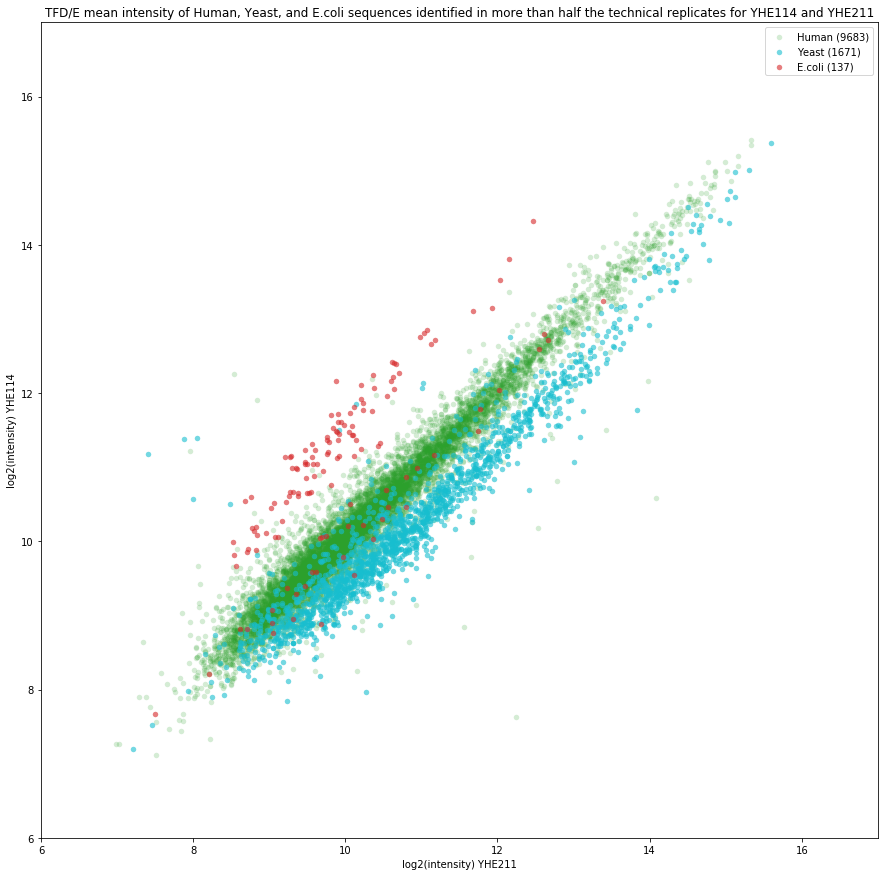

In [161]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = 'TFD/E mean intensity of Human, Yeast, and E.coli sequences identified in more than half the technical replicates for {} and {}'.format(groupA, groupB)
plt.title(title)

ax.scatter(np.log2(human_df.intensity_B), np.log2(human_df.intensity_A), marker='o', color='tab:green', lw=0, s=30, alpha=0.2, label="Human ({})".format(len(human_df)))
ax.scatter(np.log2(yeast_df.intensity_B), np.log2(yeast_df.intensity_A), marker='o', color='tab:cyan', lw=0, s=30, alpha=0.6, label="Yeast ({})".format(len(yeast_df)))
ax.scatter(np.log2(ecoli_df.intensity_B), np.log2(ecoli_df.intensity_A), marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli ({})".format(len(ecoli_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) {}'.format(groupB))
plt.ylabel('log2(intensity) {}'.format(groupA))

plt.xlim((6,17))
plt.ylim((6,17))

plt.show()

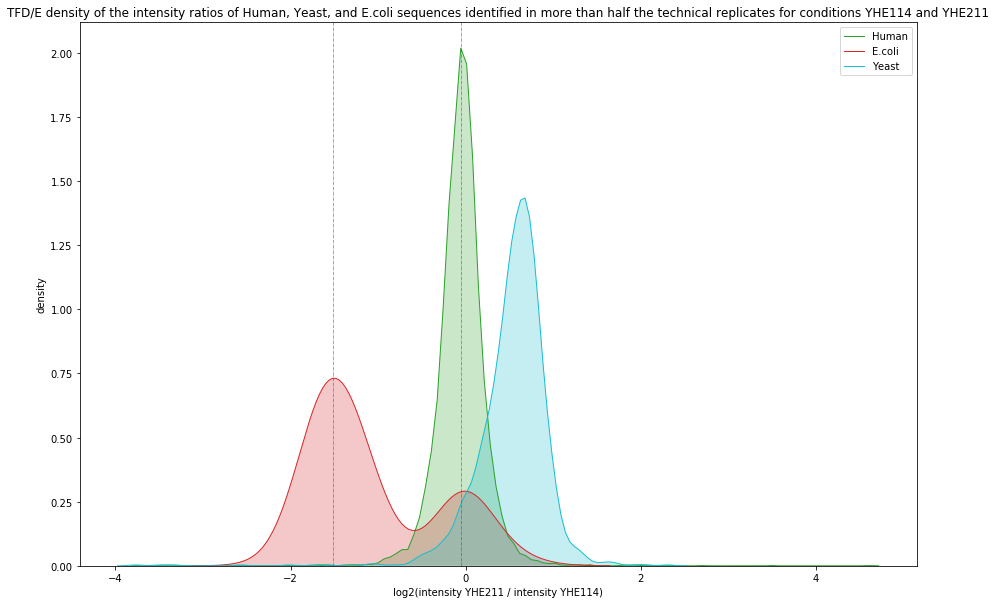

In [162]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'TFD/E density of the intensity ratios of Human, Yeast, and E.coli sequences identified in more than half the technical replicates for conditions {} and {}'.format(groupA, groupB)
plt.title(title)

# plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(np.log2(human_df['intensity_ratio']), hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(np.log2(ecoli_df['intensity_ratio']), hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'E.coli')
_ = sns.distplot(np.log2(yeast_df['intensity_ratio']), hist = False, color='tab:cyan', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Yeast')

x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
plt.axvline(x[np.argmax(y)], color='green', lw=0.5, ls='-.')

x = ax.lines[1].get_xdata()
y = ax.lines[1].get_ydata()
plt.axvline(x[np.argmax(y)], color='red', lw=0.5, ls='-.')

_ = ax.set(xlabel='log2(intensity {} / intensity {})'.format(groupB, groupA), ylabel='density')


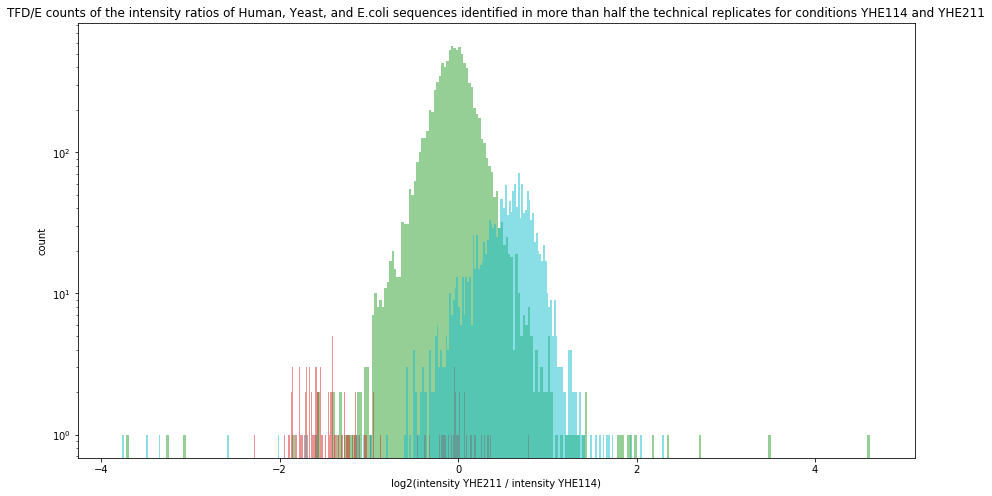

In [163]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

title = 'TFD/E counts of the intensity ratios of Human, Yeast, and E.coli sequences identified in more than half the technical replicates for conditions {} and {}'.format(groupA, groupB)
plt.margins(0.06)
plt.title(title)

bins = 300
y, x, _ = ax1.hist(np.log2(human_df['intensity_ratio']), bins=bins, color='tab:green', alpha=0.5)
y, x, _ = ax1.hist(np.log2(ecoli_df['intensity_ratio']), bins=bins, color='tab:red', alpha=0.5)
y, x, _ = ax1.hist(np.log2(yeast_df['intensity_ratio']), bins=bins, color='tab:cyan', alpha=0.5)

plt.xlabel('log2(intensity {} / intensity {})'.format(groupB, groupA))
plt.ylabel('count')
# plt.xlim((0,2))
# plt.ylim((0,60))
plt.yscale('log', basey=10, nonposy='clip')

plt.show()

#### MQ analysis

In [164]:
mq_sequences_df.columns

Index(['sequence', 'modifications', 'charge', 'species', 'short_run_name',
       'group', 'identified_in_file', 'score', 'intensity'],
      dtype='object')

In [165]:
# for each sequence and charge, if it was found in more than half the runs, 
# find the mean intensity in each group, then find the intensity ratio between groups
sequence_occurences_in_group = []
for group_name,group_df in mq_sequences_df.groupby(['sequence','modifications','charge'], as_index=False):
    sequence_in_A_df = group_df[group_df.group == groupA]
    sequence_in_B_df = group_df[group_df.group == groupB]
    if (len(sequence_in_A_df) >= int(groupA_number_of_runs / 2)) and (len(sequence_in_B_df) >= int(groupB_number_of_runs / 2)):
        average_intensity_in_A = sequence_in_A_df.intensity.mean()
        average_intensity_in_B = sequence_in_B_df.intensity.mean()
        species = group_df.iloc[0].species
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_group.append((sequence, charge, species, average_intensity_in_A, average_intensity_in_B))

In [166]:
mq_sequence_occurences_in_group_df = pd.DataFrame(sequence_occurences_in_group, columns=['sequence','charge','species','intensity_A','intensity_B'])

In [167]:
mq_sequence_occurences_in_group_df['intensity_ratio'] = mq_sequence_occurences_in_group_df.intensity_B / mq_sequence_occurences_in_group_df.intensity_A

In [168]:
human_df = mq_sequence_occurences_in_group_df[mq_sequence_occurences_in_group_df.species == 'HUMAN']
yeast_df = mq_sequence_occurences_in_group_df[mq_sequence_occurences_in_group_df.species == 'YEAST']
ecoli_df = mq_sequence_occurences_in_group_df[mq_sequence_occurences_in_group_df.species == 'E.COLI']

In [169]:
max_mq = max(np.log2(mq_sequence_occurences_in_group_df.intensity_A).max(), np.log2(mq_sequence_occurences_in_group_df.intensity_B).max())
min_mq = min(np.log2(mq_sequence_occurences_in_group_df.intensity_A).min(), np.log2(mq_sequence_occurences_in_group_df.intensity_B).min())
max_mq, min_mq

(23.926745521680008, 10.89240367575133)

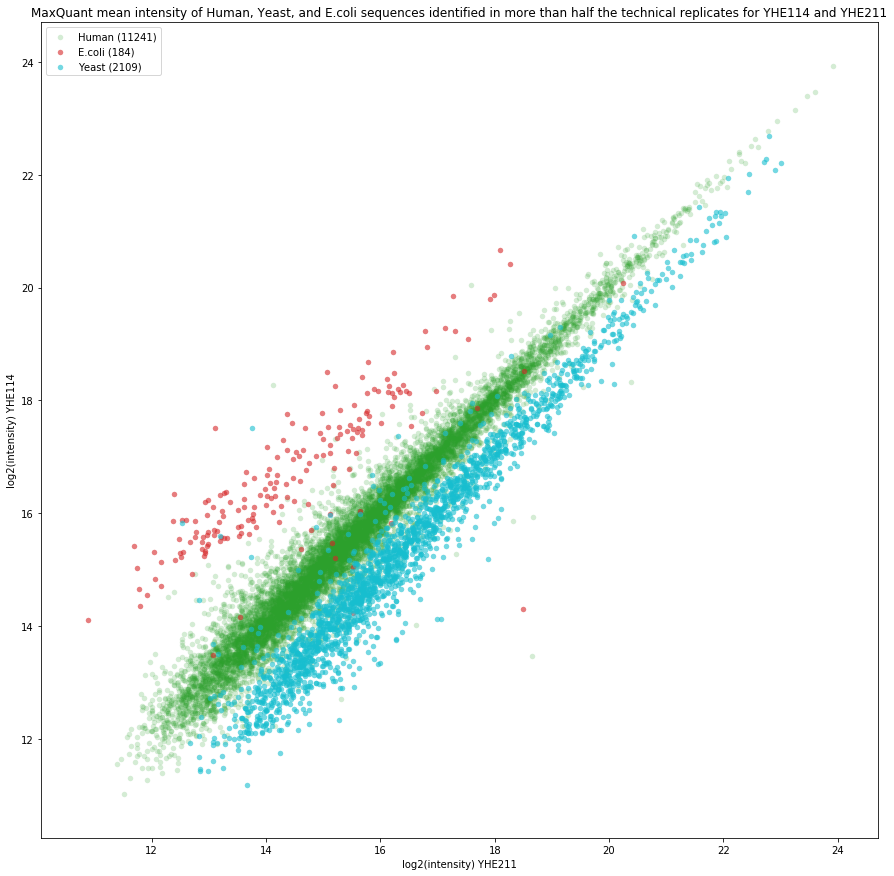

In [170]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = 'MaxQuant mean intensity of Human, Yeast, and E.coli sequences identified in more than half the technical replicates for {} and {}'.format(groupA, groupB)
plt.title(title)

ax.scatter(np.log2(human_df.intensity_B), np.log2(human_df.intensity_A), marker='o', color='tab:green', lw=0, s=30, alpha=0.2, label="Human ({})".format(len(human_df)))
ax.scatter(np.log2(ecoli_df.intensity_B), np.log2(ecoli_df.intensity_A), marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli ({})".format(len(ecoli_df)))
ax.scatter(np.log2(yeast_df.intensity_B), np.log2(yeast_df.intensity_A), marker='o', color='tab:cyan', lw=0, s=30, alpha=0.6, label="Yeast ({})".format(len(yeast_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) {}'.format(groupB))
plt.ylabel('log2(intensity) {}'.format(groupA))

# plt.xlim((7,24))
# plt.ylim((7,24))

plt.show()

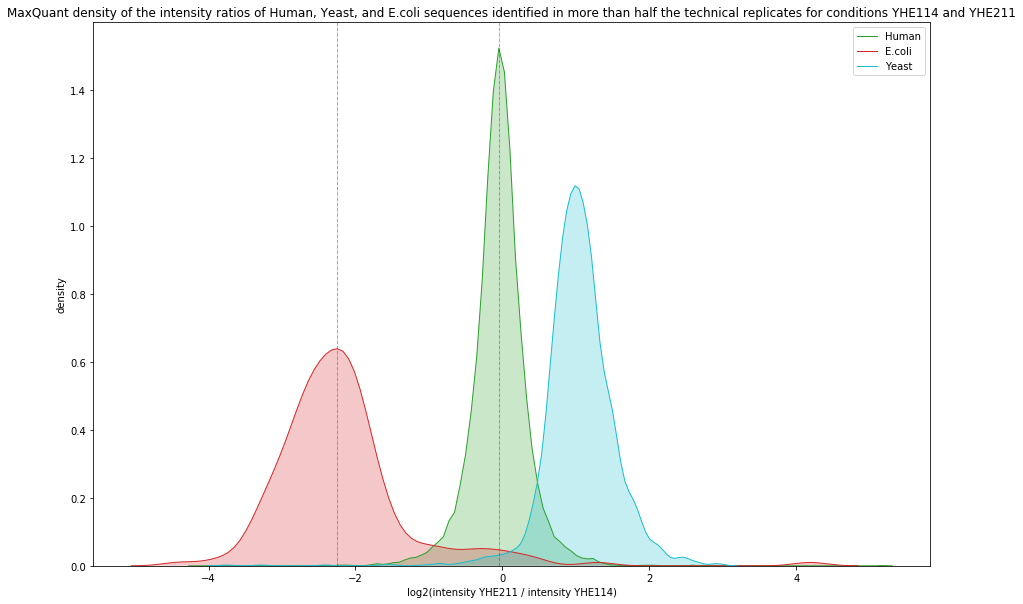

In [171]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'MaxQuant density of the intensity ratios of Human, Yeast, and E.coli sequences identified in more than half the technical replicates for conditions {} and {}'.format(groupA, groupB)
plt.title(title)

# plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(np.log2(human_df['intensity_ratio']), hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(np.log2(ecoli_df['intensity_ratio']), hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'E.coli')
_ = sns.distplot(np.log2(yeast_df['intensity_ratio']), hist = False, color='tab:cyan', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Yeast')

x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
plt.axvline(x[np.argmax(y)], color='green', lw=0.5, ls='-.')

x = ax.lines[1].get_xdata()
y = ax.lines[1].get_ydata()
plt.axvline(x[np.argmax(y)], color='red', lw=0.5, ls='-.')

_ = ax.set(xlabel='log2(intensity {} / intensity {})'.format(groupB, groupA), ylabel='density')


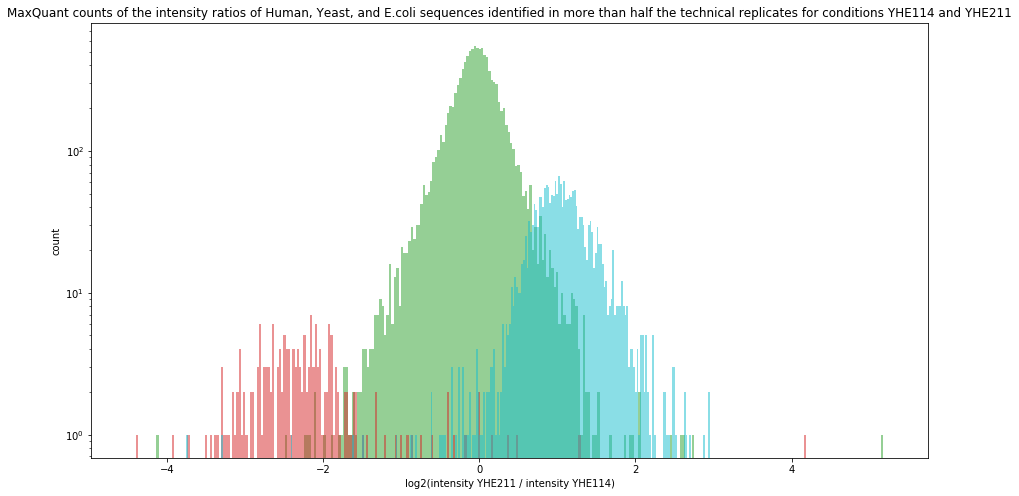

In [172]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

title = 'MaxQuant counts of the intensity ratios of Human, Yeast, and E.coli sequences identified in more than half the technical replicates for conditions {} and {}'.format(groupA, groupB)
plt.margins(0.06)
plt.title(title)

bins = 300
y, x, _ = ax1.hist(np.log2(human_df['intensity_ratio']), bins=bins, color='tab:green', alpha=0.5)
y, x, _ = ax1.hist(np.log2(ecoli_df['intensity_ratio']), bins=bins, color='tab:red', alpha=0.5)
y, x, _ = ax1.hist(np.log2(yeast_df['intensity_ratio']), bins=bins, color='tab:cyan', alpha=0.5)

plt.xlabel('log2(intensity {} / intensity {})'.format(groupB, groupA))
plt.ylabel('count')
# plt.xlim((0,2))
# plt.ylim((0,60))
plt.yscale('log', basey=10, nonposy='clip')

plt.show()

#### Fragger analysis

In [173]:
fragger_sequences_df.columns

Index(['ProteinName', 'PeptideSequence', 'PrecursorCharge', 'FragmentIon',
       'ProductCharge', 'IsotopeLabelType', 'Condition', 'BioReplicate', 'Run',
       'Intensity', 'short_run_name', 'species'],
      dtype='object')

In [174]:
# for each sequence and charge, if it was found in more than half the runs, 
# find the mean intensity in each group, then find the intensity ratio between groups
sequence_occurences_in_group = []
for group_name,group_df in fragger_sequences_df.groupby(['PeptideSequence','PrecursorCharge'], as_index=False):
    sequence_in_A_df = group_df[group_df.Condition == groupA]
    sequence_in_B_df = group_df[group_df.Condition == groupB]
    if (len(sequence_in_A_df) >= int(groupA_number_of_runs / 2)) and (len(sequence_in_B_df) >= int(groupB_number_of_runs / 2)):
        average_intensity_in_A = sequence_in_A_df.Intensity.mean()
        average_intensity_in_B = sequence_in_B_df.Intensity.mean()
        species = group_df.iloc[0].species
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_group.append((sequence, charge, species, average_intensity_in_A, average_intensity_in_B))

In [175]:
fragger_sequence_occurences_in_group_df = pd.DataFrame(sequence_occurences_in_group, columns=['sequence','charge','species','intensity_A','intensity_B'])

In [176]:
fragger_sequence_occurences_in_group_df['intensity_ratio'] = fragger_sequence_occurences_in_group_df.intensity_B / fragger_sequence_occurences_in_group_df.intensity_A

In [177]:
human_df = fragger_sequence_occurences_in_group_df[fragger_sequence_occurences_in_group_df.species == 'HUMAN']
yeast_df = fragger_sequence_occurences_in_group_df[fragger_sequence_occurences_in_group_df.species == 'YEAST']
ecoli_df = fragger_sequence_occurences_in_group_df[fragger_sequence_occurences_in_group_df.species == 'E.COLI']

In [178]:
max_fragger = max(np.log2(fragger_sequence_occurences_in_group_df.intensity_A).max(), np.log2(fragger_sequence_occurences_in_group_df.intensity_B).max())
min_fragger = min(np.log2(fragger_sequence_occurences_in_group_df.intensity_A).min(), np.log2(fragger_sequence_occurences_in_group_df.intensity_B).min())
max_fragger, min_fragger

(21.560112164042202, 9.333162942768416)

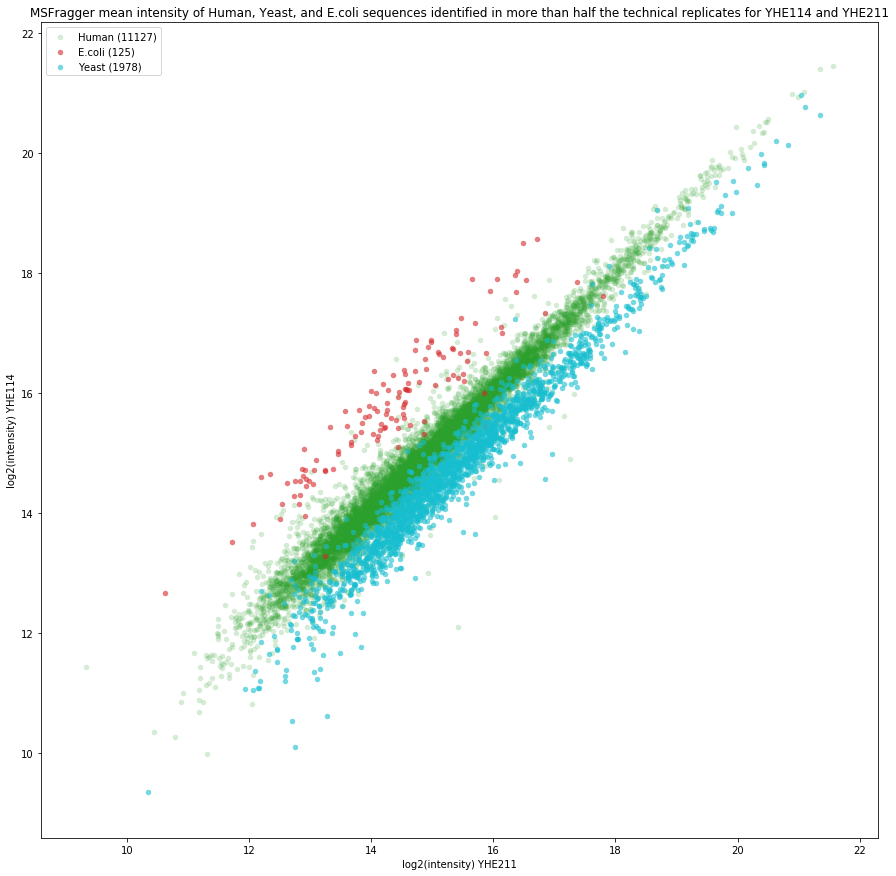

In [179]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = 'MSFragger mean intensity of Human, Yeast, and E.coli sequences identified in more than half the technical replicates for {} and {}'.format(groupA, groupB)
plt.title(title)

ax.scatter(np.log2(human_df.intensity_B), np.log2(human_df.intensity_A), marker='o', color='tab:green', lw=0, s=30, alpha=0.2, label="Human ({})".format(len(human_df)))
ax.scatter(np.log2(ecoli_df.intensity_B), np.log2(ecoli_df.intensity_A), marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli ({})".format(len(ecoli_df)))
ax.scatter(np.log2(yeast_df.intensity_B), np.log2(yeast_df.intensity_A), marker='o', color='tab:cyan', lw=0, s=30, alpha=0.6, label="Yeast ({})".format(len(yeast_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) {}'.format(groupB))
plt.ylabel('log2(intensity) {}'.format(groupA))

# plt.xlim((7,24))
# plt.ylim((7,24))

plt.show()

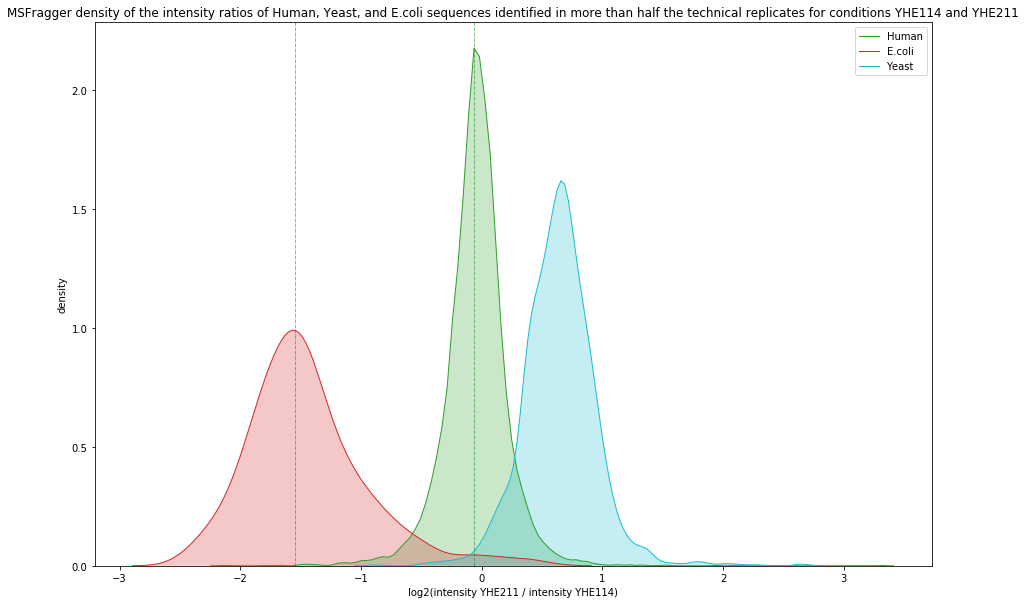

In [180]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'MSFragger density of the intensity ratios of Human, Yeast, and E.coli sequences identified in more than half the technical replicates for conditions {} and {}'.format(groupA, groupB)
plt.title(title)

# plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(np.log2(human_df['intensity_ratio']), hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(np.log2(ecoli_df['intensity_ratio']), hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'E.coli')
_ = sns.distplot(np.log2(yeast_df['intensity_ratio']), hist = False, color='tab:cyan', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Yeast')

x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
plt.axvline(x[np.argmax(y)], color='green', lw=0.5, ls='-.')

x = ax.lines[1].get_xdata()
y = ax.lines[1].get_ydata()
plt.axvline(x[np.argmax(y)], color='red', lw=0.5, ls='-.')

_ = ax.set(xlabel='log2(intensity {} / intensity {})'.format(groupB, groupA), ylabel='density')


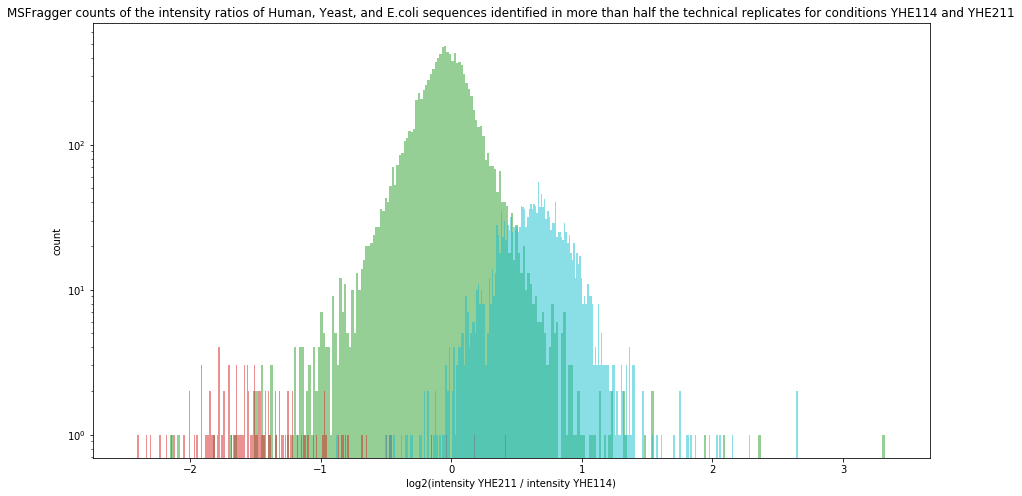

In [181]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

title = 'MSFragger counts of the intensity ratios of Human, Yeast, and E.coli sequences identified in more than half the technical replicates for conditions {} and {}'.format(groupA, groupB)
plt.margins(0.06)
plt.title(title)

bins = 300
y, x, _ = ax1.hist(np.log2(human_df['intensity_ratio']), bins=bins, color='tab:green', alpha=0.5)
y, x, _ = ax1.hist(np.log2(ecoli_df['intensity_ratio']), bins=bins, color='tab:red', alpha=0.5)
y, x, _ = ax1.hist(np.log2(yeast_df['intensity_ratio']), bins=bins, color='tab:cyan', alpha=0.5)

plt.xlabel('log2(intensity {} / intensity {})'.format(groupB, groupA))
plt.ylabel('count')
# plt.xlim((0,2))
# plt.ylim((0,60))
plt.yscale('log', basey=10, nonposy='clip')

plt.show()

In [182]:
max(max_tfde, max_mq, max_fragger), min(min_tfde, min_mq, min_fragger)

(23.926745521680008, 6.9901039638575)